In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option("display.max_columns",100)
pd.set_option('display.max_rows',100)
import time

# 共同特征
- 出院诊断病种
- 三目服务项目

In [20]:
# 出院诊断病种（共同）
disease_predictors_train = pd.read_csv("disease_predictors_train.csv",index_col=0,header=None)
disease_predictors_test = pd.read_csv("disease_predictors_test.csv",index_col=0,header=None)
predictors_test = disease_predictors_test.set_index(1).index
predictors_train = disease_predictors_train.set_index(1).index
common_disease_predictors = predictors_train.intersection(predictors_test)
common_disease_predictors.size

2269

In [24]:
"target" in common_disease_predictors

False

In [15]:
# 三目服务（共同）
service_predictors_train = pd.read_csv("service_predictors_train.csv",index_col=0,header=None)
service_predictors_test = pd.read_csv("service_predictors_test.csv",index_col=0,header=None)
predictors_test = service_predictors_test.set_index(1).index
predictors_train = service_predictors_train.set_index(1).index
common_service_predictors = predictors_train.intersection(predictors_test)
common_service_predictors.size

224

In [23]:
"target" in common_service_predictors

False

# 出院诊断病种特征数据处理

In [21]:
df_disease_feat = pd.read_csv("df_disease_feat_train.csv",index_col="个人编码")
df_disease_feat[common_disease_predictors].to_csv("df_disease_feat_train_clean.csv")
df_disease_feat = pd.read_csv("df_disease_feat_test.csv",index_col="个人编码")
df_disease_feat[common_disease_predictors].to_csv("df_disease_feat_test_clean.csv")

# 三目服务项目特征数据处理

In [16]:
df_service_feat = pd.read_csv("df_service_feat_train.csv",index_col="个人编码")
df_service_feat[common_service_predictors].to_csv("df_service_feat_train_clean.csv")
df_service_feat = pd.read_csv("df_service_feat_test.csv",index_col="个人编码")
df_service_feat[common_service_predictors].to_csv("df_service_feat_test_clean.csv")

In [17]:
#df_service_feat = pd.read_csv("df_service_feat_train.csv",index_col="个人编码")

In [18]:
#df_service_feat.shape

(20000, 368)

In [104]:
del df_disease_feat
del df_service_feat

# 出院诊断病种特征选择xgboost

In [4]:
# Import libraries:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12,4

# 为显示中文
from pylab import *  
mpl.rcParams['font.sans-serif'] = ['SimHei']

## Data Preparation

In [58]:
# Loading data
df_disease_feat = pd.read_csv("df_disease_feat_train_clean.csv",index_col='个人编码')

In [6]:
df_disease_feat.shape

(20000, 2269)

In [7]:
feat_disease = df_disease_feat.columns

In [59]:
df_origin_feat = pd.read_csv("df_data_train_clean_sparse_latest.csv",index_col="个人编码")

In [60]:
# 构建特征，以区别未提供疾病信息和提供了疾病信息的个人；未知未
df_disease_feat["disease_known_unknown"]=df_disease_feat["disease_未知"]/(df_origin_feat["trans_stat_sum"])

In [61]:
# Training and Tesing data
df_id = pd.read_csv('data/df_id_train.csv',header=None)
df_id = df_id.rename(columns={0:'Id',1:'target'})
df_train_test = df_disease_feat.join(df_id.set_index('Id'))
del df_disease_feat

In [62]:
predictors = df_train_test.columns.difference(['target'])
target = 'target'

In [30]:
df_train_test.shape

(20000, 2271)

## Spliting Training and Testing Data

In [63]:
from sklearn.model_selection import StratifiedShuffleSplit
ss = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=0)
idx_train, idx_test = ss.split(df_train_test[predictors],df_train_test[target]).next()
print 'train: ',len(idx_train)
print 'test: ',len(idx_test)
print 'ratio',float(len(idx_test))/(len(idx_train)+len(idx_test))

train:  16000
test:  4000
ratio 0.2


In [64]:
df_train = df_train_test.iloc[idx_train,:]
df_test = df_train_test.iloc[idx_test,:]

## Define a function for modeling and cross-validation

In [33]:
def modelfit(alg, dtrain, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    '''  '''
    if useTrainCV:  # 使用交叉验证选取最佳树棵树
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'],\
                          nfold=cv_folds,metrics='auc',early_stopping_rounds=early_stopping_rounds,verbose_eval=10)
        alg.set_params(n_estimators=cvresult.shape[0])

        
    # fit the algorithm on the data:
    alg.fit(dtrain[predictors], dtrain[target],eval_metric='auc')
    
    # predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    # print model report:
    print "\nModel Report"
    print 'n_estimators: ',cvresult.shape[0]
    print "Training:"
    print "Accuracy : %.4g" % metrics.accuracy_score(dtrain[target], dtrain_predictions)
    print "F1 Score : %f" % metrics.f1_score(dtrain[target],dtrain_predictions)
    print "AUC Score (Train): %f" % metrics.roc_auc_score(dtrain[target],dtrain_predprob)
    print "Classification Report : \n", metrics.classification_report(dtrain[target],dtrain_predictions)
    print ""
    
#    # predict on testing data:
#    print "Testing: "
#    dtest_predictions = alg.predict(dtest[predictors])
#    dtest_predprob = alg.predict_proba(dtest[predictors])[:,1]
#    #results = test_results.merge(dtest[['ID','predprob']], on='ID')
#    print "Accuracy : %.4g" % metrics.accuracy_score(dtest[target], dtest_predictions)
#    print "F1 Score : %f" % metrics.f1_score(dtest[target],dtest_predictions)
#    print 'AUC Score (Test): %f' % metrics.roc_auc_score(dtest[target], dtest_predprob)
#    print "Classification Report : \n", metrics.classification_report(dtest[target],dtest_predictions)
    
    feat_imp = pd.Series(alg.booster().get_score(importance_type='gain')).sort_values(ascending=False)
    feat_imp[0:60].plot(kind='bar', title='Feature Importance')
    plt.ylabel('Feature Importance Score')
    
    return feat_imp

In [12]:
xgb1 = XGBClassifier()
xgb1.fit(np.arange(0,8).reshape(4,2),[1,1,0,0])
help(xgb1.booster().get_score)

Help on method get_score in module xgboost.core:

get_score(self, fmap='', importance_type='weight') method of xgboost.core.Booster instance
    Get feature importance of each feature.
    Importance type can be defined as:
        'weight' - the number of times a feature is used to split the data across all trees.
        'gain' - the average gain of the feature when it is used in trees
        'cover' - the average coverage of the feature when it is used in trees
    
    Parameters
    ----------
    fmap: str (optional)
       The name of feature map file



## Feature Importance
### Beyond One-Hot encoding

[0]	train-auc:0.794255+0.00750567	test-auc:0.759623+0.0119108
[10]	train-auc:0.881623+0.00922206	test-auc:0.824713+0.00638018
[20]	train-auc:0.913858+0.00479173	test-auc:0.83987+0.010988
[30]	train-auc:0.938711+0.00238986	test-auc:0.849815+0.00744906
[40]	train-auc:0.952194+0.00236713	test-auc:0.853521+0.0100604
[50]	train-auc:0.959262+0.00178286	test-auc:0.856112+0.00936229
[60]	train-auc:0.963188+0.00188938	test-auc:0.855551+0.00927886
[70]	train-auc:0.966695+0.00167072	test-auc:0.855123+0.00852966
[80]	train-auc:0.969534+0.00215723	test-auc:0.854595+0.00938276
[90]	train-auc:0.972602+0.00175769	test-auc:0.85444+0.00999782

Model Report
n_estimators:  51
Training:
Accuracy : 0.9691
F1 Score : 0.555155
AUC Score (Train): 0.952742
Classification Report : 
             precision    recall  f1-score   support

          0       0.97      1.00      0.98     19000
          1       0.99      0.39      0.56      1000

avg / total       0.97      0.97      0.96     20000




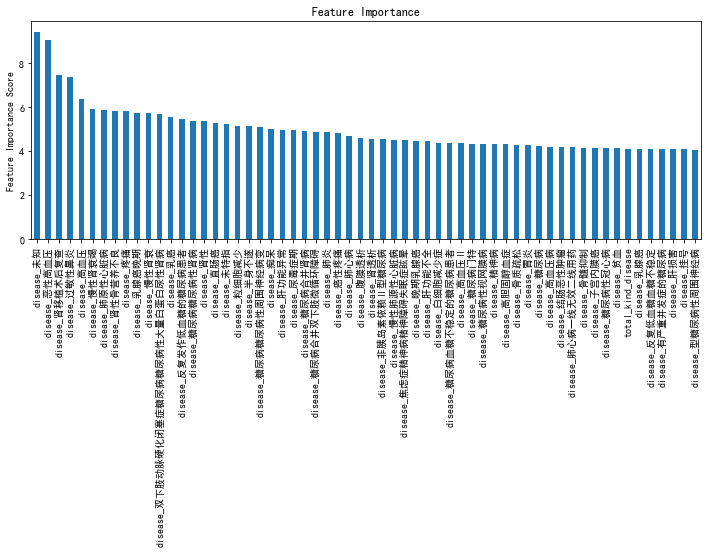

In [65]:
# new, add feature disease_known_unknown
# predictors = [x for x in train.columns if x not in [target]]
xgb1 = XGBClassifier(learning_rate = 0.1,
                    n_estimators=1000,
                    max_depth=8,
                    min_child_weight=1,
                    gamma=0,
                    subsample=0.9,
                    colsample_bytree=0.9,
                    objective='binary:logistic',
                    nthread=4,
                    scale_pos_weight=1,
                    seed=27)
feat_imp = modelfit(xgb1,df_train_test,predictors)

In [71]:
(df_train_test["disease_双下肢动脉硬化闭塞症糖尿病糖尿病性大量白蛋白尿性肾病"]!=0).sum()

14

In [72]:
feat_imp.sort_index()

disease_known_unknown                 3.754685
disease_不耐受                           3.433676
disease_中风                            4.014320
disease_中风病                           3.026607
disease_乳癌                            5.540708
disease_乳腺恶性肿瘤                        3.401290
disease_乳腺癌                           4.100688
disease_乳腺癌晚期                         5.723550
disease_伴有周围循环并发症                     2.467180
disease_伴有肾的并发症                       1.947255
disease_低蛋白血症                         2.998426
disease_偏瘫                            3.665670
disease_免疫功能低下                        0.472029
disease_冠心病                           2.048911
disease_冠状动脉粥样硬化性心脏病                  2.610665
disease_前列腺癌                          2.832130
disease_动脉硬化性心脏病                      3.042540
disease_半身不遂                          5.136777
disease_双下肢动脉硬化闭塞症糖尿病糖尿病性大量白蛋白尿性肾病    5.680848
disease_反复低血糖血糖不稳定                    4.095837
disease_反复发作低血糖                       3.147948
disease_反复发作低

In [66]:
feat_imp

disease_未知                            9.450185
disease_恶性高血压                         9.084487
disease_肾移植术后复查                       7.475071
disease_过敏性鼻炎                         7.380594
disease_高血压                           6.373368
disease_慢性肾衰竭                         5.917392
disease_肺原性心脏病                        5.871202
disease_肾性骨营养不良                       5.841887
disease_疼痛                            5.824410
disease_乳腺癌晚期                         5.723550
disease_慢性肾衰                          5.723450
disease_双下肢动脉硬化闭塞症糖尿病糖尿病性大量白蛋白尿性肾病    5.680848
disease_乳癌                            5.540708
disease_反复发作低血糖的糖尿病患者                 5.482410
disease_糖尿病糖尿病性肾病                     5.385416
disease_肾性                            5.383310
disease_直肠癌                           5.299047
disease_未特指                           5.244623
disease_粒细胞减少                         5.144780
disease_半身不遂                          5.136777
disease_糖尿病糖尿病性周围神经病变                 5.080440
disease_痴呆   

In [67]:
feat_imp.to_csv("disease_feat_importance_new.csv",encoding='utf-8')

In [68]:
feat_imp.size

171

[0]	train-auc:0.766649+0.0138382	test-auc:0.744659+0.0155026
[10]	train-auc:0.834068+0.00771608	test-auc:0.802791+0.0158325
[20]	train-auc:0.86815+0.00314165	test-auc:0.829381+0.0117356
[30]	train-auc:0.884287+0.0013605	test-auc:0.839491+0.00959953
[40]	train-auc:0.895917+0.00210995	test-auc:0.845548+0.0103679
[50]	train-auc:0.903868+0.00140959	test-auc:0.847094+0.010231
[60]	train-auc:0.910285+0.000742537	test-auc:0.848857+0.0104536
[70]	train-auc:0.91464+0.000696961	test-auc:0.849516+0.0100332
[80]	train-auc:0.918302+0.00104775	test-auc:0.849467+0.00968338
[90]	train-auc:0.921668+0.00122249	test-auc:0.84914+0.0101552
[100]	train-auc:0.924676+0.00124448	test-auc:0.848847+0.01059
[110]	train-auc:0.927786+0.00159241	test-auc:0.848772+0.0109859

Model Report
n_estimators:  70
Training:
Accuracy : 0.9647
F1 Score : 0.466415
AUC Score (Train): 0.908863
Classification Report : 
             precision    recall  f1-score   support

          0       0.96      1.00      0.98     19000
       

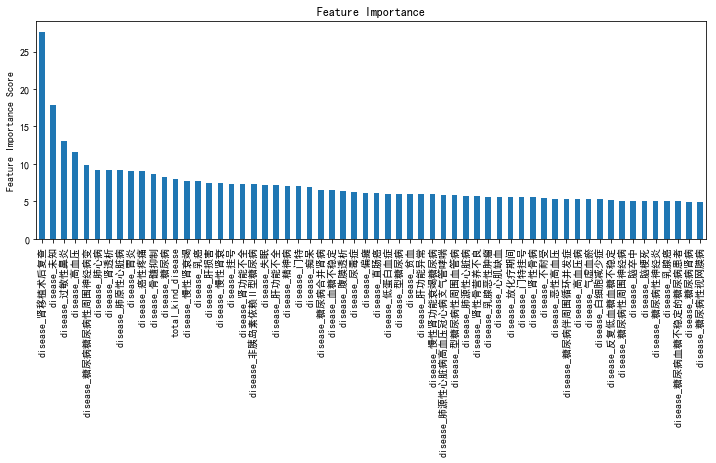

In [15]:
# choose all predictors except target & IDcols
# predictors = [x for x in train.columns if x not in [target]]
xgb1 = XGBClassifier(learning_rate = 0.1,
                    n_estimators=1000,
                    max_depth=5,
                    min_child_weight=1,
                    gamma=0,
                    subsample=0.9,
                    colsample_bytree=1,
                    objective='binary:logistic',
                    nthread=4,
                    scale_pos_weight=1,
                    seed=27)
feat_imp = modelfit(xgb1,df_train_test,predictors)

In [16]:
feat_imp/feat_imp.sum()

disease_肾移植术后复查                0.042701
disease_未知                     0.027507
disease_过敏性鼻炎                  0.020235
disease_高血压                    0.017823
disease_糖尿病糖尿病性周围神经病变          0.015169
disease_肺心病                    0.014173
disease_肾透析                    0.014127
disease_肺原性心脏病                 0.014093
disease_胃炎                     0.014048
disease_癌性疼痛                   0.014028
disease_骨髓抑制                   0.013404
disease_糖尿病                    0.012652
total_kind_disease             0.012279
disease_慢性肾衰竭                  0.011960
disease_乳癌                     0.011877
disease_肝损害                    0.011572
disease_慢性肾衰                   0.011448
disease_挂号                     0.011397
disease_肾功能不全                  0.011275
disease_非胰岛素依赖Ⅱ型糖尿病            0.011236
disease_失眠                     0.011167
disease_肝功能不全                  0.011009
disease_精神病                    0.010904
disease_门特                     0.010902
disease_痴呆                     0.010680


In [18]:
feat_imp.to_csv("disease_feat_importance.csv",encoding='utf-8')

In [33]:
feat_imp = pd.read_csv("disease_feat_importance.csv",index_col=0,header=None)

In [34]:
feat_imp.index[feat_imp.index.str.startswith("disease_过")]

Index([u'disease_过敏性鼻炎'], dtype='object', name=0)

### Try One-Hot Enconding

In [54]:
df_train_test['disease_未知']

个人编码
352120000000231    1
352120000000386    1
352120000000408    1
352120000000409    1
352120000000511    1
352120000000674    1
352120000000767    1
352120000001361    1
352120000001462    1
352120000001641    1
352120000001710    1
352120000001823    1
352120000001866    1
352120000001950    1
352120000002052    1
352120000002090    1
352120000002163    1
352120000002315    1
352120000002987    1
352120000003190    1
352120000003350    1
352120000003632    1
352120000003749    1
352120000003852    1
352120000003953    1
352120000004176    1
352120000004265    1
352120000004286    1
352120000004310    1
352120000004420    1
352120000004661    1
352120000004790    1
352120000004990    1
352120000005132    1
352120000005778    1
352120000005883    1
352120000005905    1
352120000006616    1
352120000006765    1
352120000006860    1
352120000006884    1
352120000006914    1
352120000007297    1
352120000007709    1
352120000007943    1
352120000007965    1
352120000008151    1
35212000

In [19]:
# One-Hot encoding
df_train_test1 = df_train_test.drop("disease_未知",axis=1)
df_train_test1[df_train_test1 != 0] = 1


In [56]:
df_train = df_train_test1.iloc[idx_train,:]
df_test = df_train_test1.iloc[idx_test,:]

[0]	train-auc:0.66795+0.00280896	test-auc:0.663874+0.0102044
[10]	train-auc:0.701787+0.0121644	test-auc:0.691367+0.0134838
[20]	train-auc:0.740318+0.00579205	test-auc:0.725517+0.0148783
[30]	train-auc:0.757022+0.0030177	test-auc:0.733898+0.0207915
[40]	train-auc:0.77402+0.003047	test-auc:0.736218+0.0191296
[50]	train-auc:0.788001+0.00271756	test-auc:0.737502+0.0193433
[60]	train-auc:0.79605+0.0032196	test-auc:0.737965+0.017061
[70]	train-auc:0.804806+0.00282902	test-auc:0.738747+0.0163576
[80]	train-auc:0.808899+0.00343737	test-auc:0.736843+0.0174119
[90]	train-auc:0.813799+0.00452247	test-auc:0.737875+0.0182774
[100]	train-auc:0.818739+0.00340397	test-auc:0.737888+0.0174843
[110]	train-auc:0.821806+0.00378704	test-auc:0.737666+0.0178259

Model Report
n_estimators:  68
Training:
Accuracy : 0.9579
F1 Score : 0.293871
AUC Score (Train): 0.797384
Classification Report : 
             precision    recall  f1-score   support

          0       0.96      1.00      0.98     19000
          1 

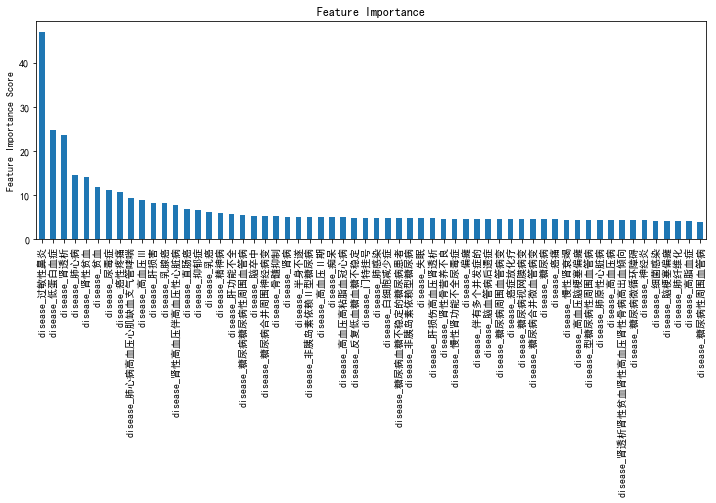

In [23]:
# choose all predictors except target & IDcols
predictors = df_train_test1.columns.difference(['target'])
xgb2 = XGBClassifier(learning_rate = 0.1,
                    n_estimators=1000,
                    max_depth=5,
                    min_child_weight=1,
                    gamma=0,
                    subsample=0.9,
                    colsample_bytree=1,
                    objective='binary:logistic',
                    nthread=4,
                    scale_pos_weight=1,
                    seed=27)
feat_imp2 = modelfit(xgb2,df_train_test1,predictors)

In [35]:
feat_imp2.to_csv("disease_feat_importance_onehot.csv",encoding='utf-8')

#### Comments

- One-Hot-Encoding 不及带权值的特征好
- disease-未知特征占有很大比重，如果去掉该特征呢？？

### Drop The Most Important Feature

In [61]:
df_train_test.drop("disease_未知",axis=1,inplace=True)
df_train = df_train_test.iloc[idx_train,:]
df_test = df_train_test.iloc[idx_test,:]

[0]	train-auc:0.641257+0.00888562	test-auc:0.620069+0.0209501
[10]	train-auc:0.751717+0.00550071	test-auc:0.734282+0.0174049
[20]	train-auc:0.78141+0.00298366	test-auc:0.751927+0.0176
[30]	train-auc:0.806417+0.00625363	test-auc:0.763994+0.0175741
[40]	train-auc:0.826881+0.00629674	test-auc:0.766575+0.0161445
[50]	train-auc:0.840398+0.0052691	test-auc:0.770371+0.0163568
[60]	train-auc:0.850725+0.00459216	test-auc:0.771649+0.0144058
[70]	train-auc:0.85767+0.00438358	test-auc:0.773585+0.0142185
[80]	train-auc:0.865559+0.00380854	test-auc:0.774257+0.013009
[90]	train-auc:0.87108+0.00426038	test-auc:0.77374+0.0136894
[100]	train-auc:0.876519+0.00383101	test-auc:0.774139+0.0135899
[110]	train-auc:0.880594+0.00314223	test-auc:0.773156+0.0148634
[120]	train-auc:0.886268+0.00394958	test-auc:0.772189+0.0138135
[130]	train-auc:0.889827+0.00353707	test-auc:0.772169+0.0128021
[140]	train-auc:0.894131+0.00354186	test-auc:0.773227+0.0121547
[150]	train-auc:0.89795+0.00334128	test-auc:0.773323+0.01191

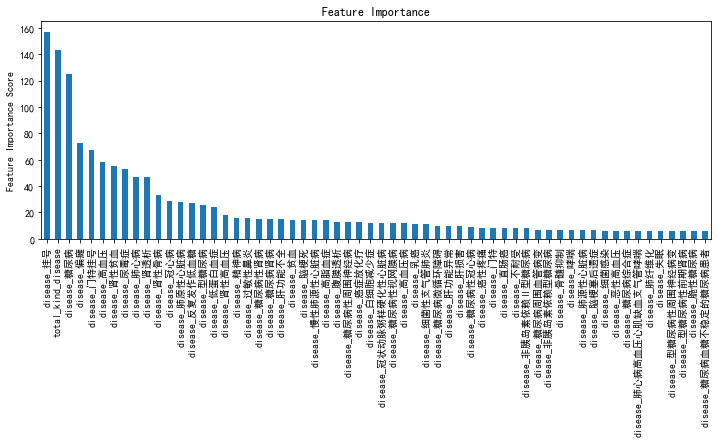

In [62]:
# choose all predictors except target & IDcols
predictors = df_train.columns.difference(['target'])
xgb3 = XGBClassifier(learning_rate = 0.1,
                    n_estimators=1000,
                    max_depth=5,
                    min_child_weight=1,
                    gamma=0,
                    subsample=0.9,
                    colsample_bytree=0.9,
                    objective='binary:logistic',
                    nthread=4,
                    scale_pos_weight=1,
                    seed=27)
feat_imp3 = modelfit(xgb3,df_train,df_test,predictors)

In [113]:
feat_imp3.to_csv("disease_feat_importance_real.csv",encoding='utf-8')

## Conclusion

- 加权的特征比类别0-1特征表现要好
- disease-未知特征占有很大比重，很重要，从f1得分来看，其也是很重要的，这说明什么？未知也能提供信息？？

#  三目服务特征选择xgboost

## Data Preparation

In [38]:
# Loading data
df_service_feat = pd.read_csv("df_service_feat_train_clean.csv",index_col='个人编码')

In [39]:
df_service_feat.columns = df_service_feat.columns.str.replace("[\[\]]",'_').str.replace("<","_").str.replace("☆","_").str.replace("、","_")
#df_service_feat.to_csv("df_service_feat_train_clean.csv")

In [41]:
df_service_feat["service_known_unknown"] = df_service_feat["service_未知"]/df_origin_feat["trans_stat_sum"]

In [42]:
# Training and Tesing data
df_id = pd.read_csv('data/df_id_train.csv',header=None)
df_id = df_id.rename(columns={0:'Id',1:'target'})
df_train_test = df_service_feat.join(df_id.set_index('Id'))
#del df_service_feat

In [51]:
predictors = df_train_test.columns.difference(['target','service_未知'])
target = 'target'

In [9]:
predictors.size

224

In [23]:
df_service_feat.shape

(20000, 224)

In [24]:
df_train_test[predictors].shape

(20000, 224)

## Spliting Training and Testing Data

In [44]:
from sklearn.model_selection import StratifiedShuffleSplit
ss = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=0)
idx_train, idx_test = ss.split(df_train_test[predictors],df_train_test[target]).next()
print 'train: ',len(idx_train)
print 'test: ',len(idx_test)
print 'ratio',float(len(idx_test))/(len(idx_train)+len(idx_test))

train:  16000
test:  4000
ratio 0.2


In [45]:
df_train = df_train_test.iloc[idx_train,:]
df_test = df_train_test.iloc[idx_test,:]

## Feature Importance

[0]	train-auc:0.658503+0.00596071	test-auc:0.648773+0.0170993
[10]	train-auc:0.736654+0.0273885	test-auc:0.720745+0.0225674
[20]	train-auc:0.78894+0.00614189	test-auc:0.767693+0.0131692
[30]	train-auc:0.819872+0.00400545	test-auc:0.786508+0.0133839
[40]	train-auc:0.839508+0.00381996	test-auc:0.798316+0.012255
[50]	train-auc:0.850611+0.00407266	test-auc:0.802076+0.00980946
[60]	train-auc:0.860599+0.00438469	test-auc:0.805169+0.0106056
[70]	train-auc:0.870016+0.00266549	test-auc:0.807844+0.00902353
[80]	train-auc:0.875925+0.00316998	test-auc:0.809191+0.00828039
[90]	train-auc:0.883066+0.00356224	test-auc:0.811291+0.00827209
[100]	train-auc:0.889669+0.0023707	test-auc:0.813061+0.00991602
[110]	train-auc:0.894655+0.00297013	test-auc:0.815304+0.00981891
[120]	train-auc:0.898695+0.00303936	test-auc:0.815426+0.00862302
[130]	train-auc:0.902534+0.00278034	test-auc:0.81619+0.00702471
[140]	train-auc:0.906184+0.0030442	test-auc:0.815967+0.0070484
[150]	train-auc:0.90955+0.0029837	test-auc:0.8164

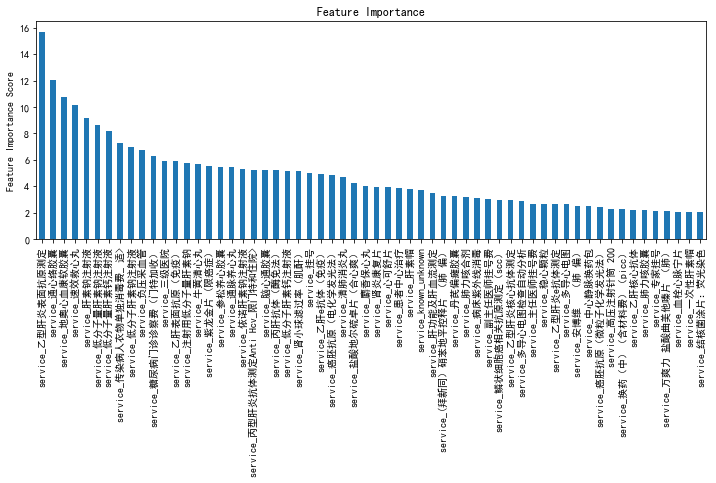

In [52]:
# new, add feature service_known_unknown
# predictors = [x for x in train.columns if x not in [target]]
xgb1 = XGBClassifier(learning_rate = 0.1,
                    n_estimators=1000,
                    max_depth=5,
                    min_child_weight=1,
                    gamma=0,
                    subsample=0.9,
                    colsample_bytree=1,
                    objective='binary:logistic',
                    nthread=4,
                    scale_pos_weight=1,
                    seed=27)
service_feat_imp = modelfit(xgb1,df_train_test,predictors)

In [53]:
service_feat_imp["service_known_unknown"]

3.6871986203389859

In [54]:
service_feat_imp.size

74

[0]	train-auc:0.778459+0.0127436	test-auc:0.763819+0.0111361
[10]	train-auc:0.835484+0.00803309	test-auc:0.81539+0.019003
[20]	train-auc:0.862783+0.00218542	test-auc:0.834054+0.0100313
[30]	train-auc:0.879114+0.00171951	test-auc:0.844318+0.00935443
[40]	train-auc:0.887629+0.00120717	test-auc:0.848775+0.00878096
[50]	train-auc:0.894069+0.00161078	test-auc:0.851271+0.00942007
[60]	train-auc:0.899045+0.00215059	test-auc:0.852053+0.00920359
[70]	train-auc:0.902965+0.00210952	test-auc:0.852809+0.00925724
[80]	train-auc:0.906462+0.00181149	test-auc:0.853807+0.0091608
[90]	train-auc:0.909405+0.00126878	test-auc:0.854086+0.00973737
[100]	train-auc:0.912208+0.00156102	test-auc:0.854802+0.0100805
[110]	train-auc:0.914867+0.00195899	test-auc:0.854299+0.0101137
[120]	train-auc:0.917205+0.00209555	test-auc:0.854624+0.010125
[130]	train-auc:0.919196+0.00203039	test-auc:0.854662+0.00992003
[140]	train-auc:0.921408+0.00172589	test-auc:0.854517+0.00989866

Model Report
n_estimators:  101
Training:
Accu

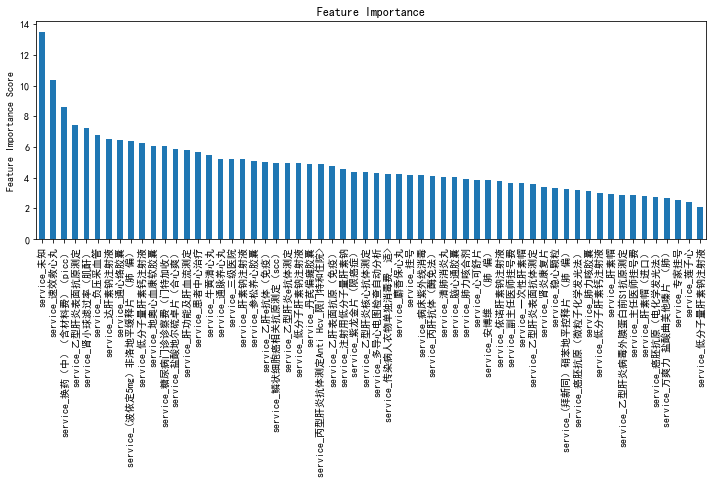

In [25]:
# choose all predictors except target & IDcols
# predictors = [x for x in train.columns if x not in [target]]
xgb1 = XGBClassifier(learning_rate = 0.1,
                    n_estimators=1000,
                    max_depth=5,
                    min_child_weight=1,
                    gamma=0,
                    subsample=0.9,
                    colsample_bytree=1,
                    objective='binary:logistic',
                    nthread=4,
                    scale_pos_weight=1,
                    seed=27)
service_feat_imp = modelfit(xgb1,df_train_test,predictors)

In [27]:
service_feat_imp.size

65

- 未知特征占有很大比重，why？这不是问题的本质所在
- 需要注意该特征其实是表示缺失的特征，暗含了交易的频次，因此其显得很重要

In [28]:
service_feat_imp.to_csv("service_feat_importance.csv",encoding='utf-8')

## One-Hot Encoding

In [30]:
# One-Hot encoding
df_train_test1 = df_train_test.drop("service_未知",axis=1)
df_train_test1[df_train_test1 != 0] = 1

[0]	train-auc:0.648401+0.0108463	test-auc:0.635918+0.0208154
[10]	train-auc:0.689293+0.00623064	test-auc:0.679762+0.00727859
[20]	train-auc:0.70367+0.0040457	test-auc:0.694273+0.0121786
[30]	train-auc:0.740687+0.00760929	test-auc:0.720745+0.0165118
[40]	train-auc:0.754768+0.00522194	test-auc:0.728762+0.0211878
[50]	train-auc:0.758594+0.00537306	test-auc:0.731391+0.0211099
[60]	train-auc:0.762104+0.00485323	test-auc:0.732846+0.0203071
[70]	train-auc:0.765012+0.00447786	test-auc:0.733696+0.0193842
[80]	train-auc:0.767014+0.00497541	test-auc:0.732045+0.01798
[90]	train-auc:0.769115+0.00525808	test-auc:0.732138+0.0173543
[100]	train-auc:0.770872+0.00522529	test-auc:0.731948+0.0169422
[110]	train-auc:0.772425+0.00525106	test-auc:0.731493+0.016324
[120]	train-auc:0.77365+0.0050768	test-auc:0.73174+0.0159424

Model Report
n_estimators:  72
Training:
Accuracy : 0.9542
F1 Score : 0.193662
AUC Score (Train): 0.759953
Classification Report : 
             precision    recall  f1-score   support



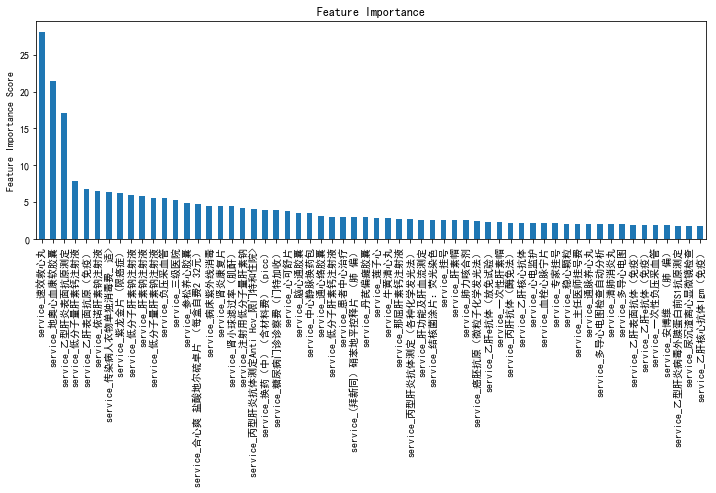

In [31]:
# choose all predictors except target & IDcols
predictors = df_train_test1.columns.difference(['target'])
xgb2 = XGBClassifier(learning_rate = 0.1,
                    n_estimators=1000,
                    max_depth=5,
                    min_child_weight=1,
                    gamma=0,
                    subsample=0.9,
                    colsample_bytree=1,
                    objective='binary:logistic',
                    nthread=4,
                    scale_pos_weight=1,
                    seed=27)
service_feat_imp2 = modelfit(xgb2,df_train_test1,predictors)

In [43]:
service_feat_imp2.size

79

In [34]:
service_feat_imp2.to_csv("service_feat_importance_onehot.csv",encoding='utf-8')

## Drop The Most Important Feature

[0]	train-auc:0.645934+0.00583665	test-auc:0.637754+0.0210998
[10]	train-auc:0.748392+0.010432	test-auc:0.733423+0.0223548
[20]	train-auc:0.783165+0.0107701	test-auc:0.756613+0.0215063
[30]	train-auc:0.807044+0.00795055	test-auc:0.774091+0.0226924
[40]	train-auc:0.822986+0.00604221	test-auc:0.7809+0.0236028
[50]	train-auc:0.830725+0.00556994	test-auc:0.783363+0.0252573
[60]	train-auc:0.837043+0.0024704	test-auc:0.785668+0.0254922
[70]	train-auc:0.843907+0.00174775	test-auc:0.78502+0.0255839
[80]	train-auc:0.849522+0.00201842	test-auc:0.784166+0.0252266
[90]	train-auc:0.854258+0.000987726	test-auc:0.784164+0.024433
[100]	train-auc:0.858949+0.00195862	test-auc:0.784696+0.0234707
[110]	train-auc:0.863035+0.002258	test-auc:0.78548+0.0242524

Model Report
n_estimators:  62
Training:
Accuracy : 0.9596
F1 Score : 0.327083
AUC Score (Train): 0.833902
Classification Report : 
             precision    recall  f1-score   support

          0       0.96      1.00      0.98     15200
          1  

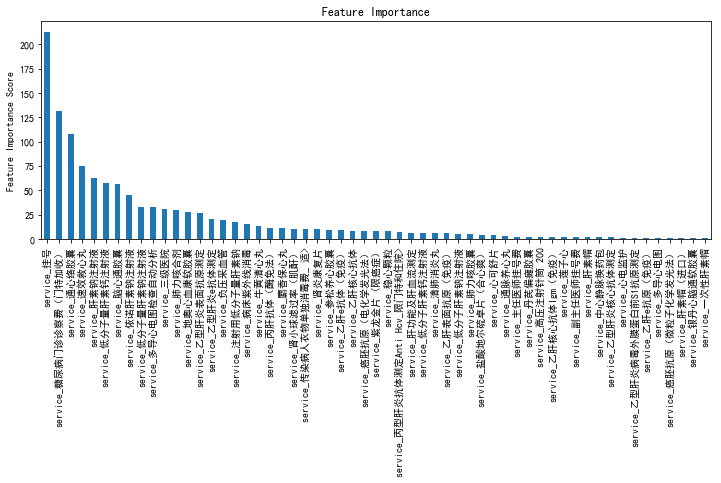

In [115]:
# choose all predictors except target & IDcols
predictors = df_train.columns.difference(["target","service_未知"])
xgb2 = XGBClassifier(learning_rate = 0.1,
                    n_estimators=1000,
                    max_depth=5,
                    min_child_weight=1,
                    gamma=0,
                    subsample=0.9,
                    colsample_bytree=1,
                    objective='binary:logistic',
                    nthread=4,
                    scale_pos_weight=1,
                    seed=27)
service_feat_imp2 = modelfit(xgb2,df_train,df_test,predictors)

In [116]:
service_feat_imp2.to_csv("service_feat_importance_real.csv",encoding='utf-8')

## Conclusion

- 三目服务项目特征重要性相对出院诊断病种的重要性；
- 因此，在选择特征时，出院诊断病种特征数量应该取得更多
- 估计:
    - 出院诊断病种特征数量top：40-60
    - 三目服务项目特征数量top：20-40

# 去医院频率特征

In [63]:
df_train_test = pd.read_csv("df_data_train_clean_sparse_latest.csv",index_col="个人编码")

In [64]:
# 所有特征
features = df_train_test.columns.difference(['target'])

In [37]:
# 去各个医院的频率特征
predictors = features[features.str.startswith("freq_hospital_")]
target = 'target'

In [131]:
# 数据准备
from sklearn.model_selection import StratifiedShuffleSplit
ss = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=0)
idx_train, idx_test = ss.split(df_train_test[predictors],df_train_test[target]).next()
print 'train: ',len(idx_train)
print 'test: ',len(idx_test)
print 'ratio',float(len(idx_test))/(len(idx_train)+len(idx_test))

train:  16000
test:  4000
ratio 0.2


In [132]:
df_train = df_train_test.iloc[idx_train,:]
df_test = df_train_test.iloc[idx_test,:]

## Feature Importance

[0]	train-auc:0.586087+0.00375122	test-auc:0.578014+0.00675689
[10]	train-auc:0.660082+0.00649055	test-auc:0.630695+0.0108245
[20]	train-auc:0.694818+0.003391	test-auc:0.664432+0.0262207
[30]	train-auc:0.726229+0.0062467	test-auc:0.681013+0.0223178
[40]	train-auc:0.753262+0.00325719	test-auc:0.704828+0.0192668
[50]	train-auc:0.767574+0.00594072	test-auc:0.708459+0.0170888
[60]	train-auc:0.783868+0.00318763	test-auc:0.718287+0.0157322
[70]	train-auc:0.798262+0.00320453	test-auc:0.722287+0.0099726
[80]	train-auc:0.808749+0.00176358	test-auc:0.727765+0.00883925
[90]	train-auc:0.815866+0.00219771	test-auc:0.73012+0.00896036
[100]	train-auc:0.822097+0.00295897	test-auc:0.732481+0.00768977
[110]	train-auc:0.82801+0.00308328	test-auc:0.734977+0.0108316
[120]	train-auc:0.833094+0.00262107	test-auc:0.735455+0.0121299
[130]	train-auc:0.837808+0.00351969	test-auc:0.736713+0.00995801
[140]	train-auc:0.841819+0.0034678	test-auc:0.73999+0.0095886
[150]	train-auc:0.845027+0.00312731	test-auc:0.740494

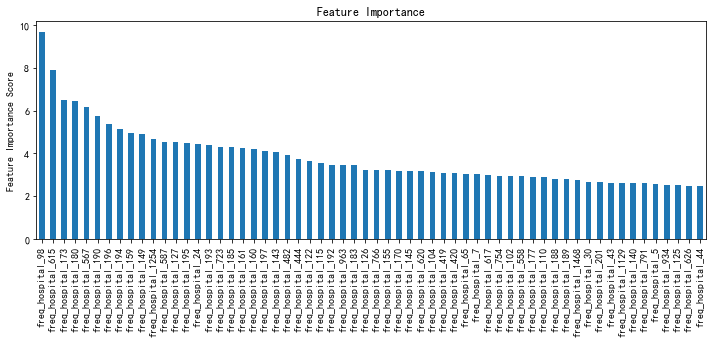

In [39]:
# choose all predictors except target & IDcols
# predictors = [x for x in train.columns if x not in [target]]
xgb1 = XGBClassifier(learning_rate = 0.1,
                    n_estimators=1000,
                    max_depth=5,
                    min_child_weight=1,
                    gamma=0,
                    subsample=0.9,
                    colsample_bytree=1,
                    objective='binary:logistic',
                    nthread=4,
                    scale_pos_weight=1,
                    seed=27)
feat_freq_hospital_imp1 = modelfit(xgb1,df_train_test,predictors)

In [42]:
feat_freq_hospital_imp1.to_csv("feat_freq_hospital_imp.csv")

In [40]:
feat_freq_hospital_imp1.size

120

In [41]:
predictors.size

347

## Conclusion

- 该特征相对于三目及出院诊断来说不那么重要，可取特征数量10-20

# 在各个医院交易特征

In [65]:
# 在各个医院的交易特征
predictors = features[features.str.startswith("freq_trans_")]
target = 'target'

In [137]:
df_train = df_train_test.iloc[idx_train,:]
df_test = df_train_test.iloc[idx_test,:]

## Feature Importance

[0]	train-auc:0.58931+0.00977756	test-auc:0.58041+0.00883288
[10]	train-auc:0.644343+0.00607065	test-auc:0.626139+0.0149802
[20]	train-auc:0.685041+0.00968495	test-auc:0.656913+0.0203657
[30]	train-auc:0.727114+0.0141699	test-auc:0.677983+0.0127673
[40]	train-auc:0.753052+0.00441111	test-auc:0.695081+0.0127692
[50]	train-auc:0.780564+0.00468867	test-auc:0.704012+0.0112533
[60]	train-auc:0.798005+0.00432725	test-auc:0.710611+0.0126797
[70]	train-auc:0.816428+0.00208959	test-auc:0.721+0.00761114
[80]	train-auc:0.827294+0.00272996	test-auc:0.7285+0.00897266
[90]	train-auc:0.836002+0.00270435	test-auc:0.733839+0.0077949
[100]	train-auc:0.842263+0.0024131	test-auc:0.739546+0.00659977
[110]	train-auc:0.848171+0.0027164	test-auc:0.741776+0.0060024
[120]	train-auc:0.852799+0.00282053	test-auc:0.743339+0.00476989
[130]	train-auc:0.857892+0.00271267	test-auc:0.746113+0.0050069
[140]	train-auc:0.861872+0.00227695	test-auc:0.747453+0.00524296
[150]	train-auc:0.864857+0.00219882	test-auc:0.748747+0

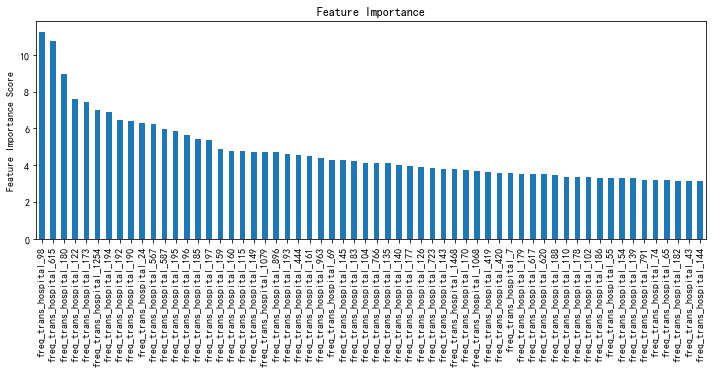

In [66]:
# choose all predictors except target & IDcols
# predictors = [x for x in train.columns if x not in [target]]
xgb1 = XGBClassifier(learning_rate = 0.1,
                    n_estimators=1000,
                    max_depth=5,
                    min_child_weight=1,
                    gamma=0,
                    subsample=0.9,
                    colsample_bytree=1,
                    objective='binary:logistic',
                    nthread=4,
                    scale_pos_weight=1,
                    seed=27)
feat_freq_trans_imp1 = modelfit(xgb1,df_train_test,predictors)

In [67]:
feat_freq_trans_imp1.size

103

In [68]:
feat_freq_trans_imp1.to_csv("feat_freq_trans_imp.csv")

In [166]:
feat_freq_trans_imp1[-60:]

freq_trans_hospital_617     13
freq_trans_hospital_635     13
freq_trans_hospital_723     13
freq_trans_hospital_155     12
freq_trans_hospital_201     12
freq_trans_hospital_144     11
freq_trans_hospital_420     11
freq_trans_hospital_105     11
freq_trans_hospital_65      11
freq_trans_hospital_1068    11
freq_trans_hospital_178     10
freq_trans_hospital_571     10
freq_trans_hospital_1129    10
freq_trans_hospital_154      9
freq_trans_hospital_42       9
freq_trans_hospital_43       9
freq_trans_hospital_449      8
freq_trans_hospital_77       8
freq_trans_hospital_766      7
freq_trans_hospital_1079     7
freq_trans_hospital_78       6
freq_trans_hospital_26       6
freq_trans_hospital_1121     6
freq_trans_hospital_569      6
freq_trans_hospital_64       5
freq_trans_hospital_34       5
freq_trans_hospital_791      5
freq_trans_hospital_554      5
freq_trans_hospital_692      5
freq_trans_hospital_55       5
freq_trans_hospital_934      4
freq_trans_hospital_127      4
freq_tra

## Conclusion

- 相对于去医院的频率来说，该特征信息量较大，但频率特征信息量都小于三目和出院诊断
- 建议取特征量top：20-40
- 该特征似乎与去医院的频率特征存在信息交叉，也许选取其中一个就可以了，建议选择在各个医院的交易频率

# 时间间隔特征

In [44]:
# 去除重复的列
def duplicate_columns(frame):
    groups = frame.columns.to_series().groupby(frame.dtypes).groups
    dups = []
    for t, v in groups.items():
        dcols = frame[v].to_dict(orient="list")

        vs = dcols.values()
        ks = dcols.keys()
        lvs = len(vs)

        for i in range(lvs):
            for j in range(i+1,lvs):
                if vs[i] == vs[j]: 
                    dups.append(ks[i])
                    break

    return dups

In [48]:
predictors = features[features.str.startswith("every_period_")]
dups = duplicate_columns(df_train_test[predictors])

In [49]:
print "Total: ",len(predictors)
print "Duplicate: ",len(dups)

Total:  194
Duplicate:  97


In [50]:
predictors = predictors.difference(dups)
target = 'target'

## Feature Importance

[0]	train-auc:0.675683+0.0122083	test-auc:0.666823+0.012661
[10]	train-auc:0.77171+0.0111697	test-auc:0.743107+0.0192134
[20]	train-auc:0.802813+0.00544633	test-auc:0.756775+0.0176339
[30]	train-auc:0.837282+0.00292942	test-auc:0.769326+0.0209794
[40]	train-auc:0.863548+0.0040623	test-auc:0.778865+0.0204091
[50]	train-auc:0.88026+0.00230875	test-auc:0.788524+0.0193029
[60]	train-auc:0.89196+0.00283604	test-auc:0.791415+0.0188233
[70]	train-auc:0.900829+0.00266626	test-auc:0.79364+0.0197839
[80]	train-auc:0.907404+0.00199883	test-auc:0.794665+0.0191003
[90]	train-auc:0.913548+0.00207661	test-auc:0.79439+0.0186633
[100]	train-auc:0.919301+0.00194223	test-auc:0.795229+0.0188438
[110]	train-auc:0.923721+0.00173152	test-auc:0.795287+0.0197737
[120]	train-auc:0.927806+0.00196082	test-auc:0.79481+0.0192276
[130]	train-auc:0.931975+0.00218599	test-auc:0.793372+0.0193762
[140]	train-auc:0.935466+0.00219979	test-auc:0.793378+0.0192403

Model Report
n_estimators:  98
Training:
Accuracy : 0.9594
F

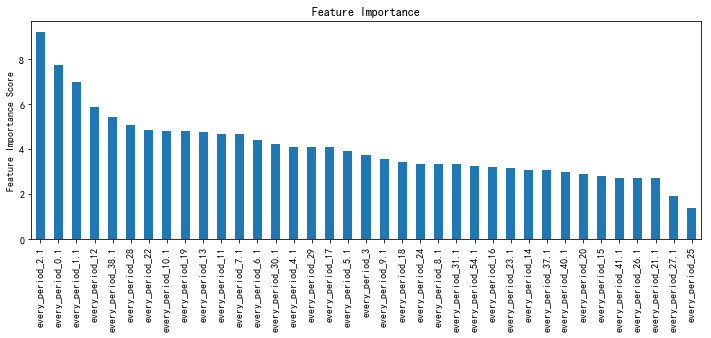

In [58]:
# choose all predictors except target & IDcols
# predictors = [x for x in train.columns if x not in [target]]
xgb1 = XGBClassifier(learning_rate = 0.1,
                    n_estimators=1000,
                    max_depth=5,
                    min_child_weight=1,
                    gamma=0,
                    subsample=0.9,
                    colsample_bytree=1,
                    objective='binary:logistic',
                    nthread=4,
                    scale_pos_weight=1,
                    seed=27)
feat_every_period_imp1 = modelfit(xgb1,df_train_test,predictors)

In [61]:
feat_every_period_imp1

every_period_2.1     9.234405
every_period_0.1     7.740481
every_period_1.1     6.968233
every_period_12      5.861816
every_period_38.1    5.426930
every_period_28      5.079716
every_period_22      4.848394
every_period_10.1    4.792540
every_period_19      4.783644
every_period_13      4.734855
every_period_11      4.684514
every_period_7.1     4.661043
every_period_6.1     4.416532
every_period_30.1    4.212790
every_period_4.1     4.096171
every_period_29      4.092245
every_period_17      4.079516
every_period_5.1     3.924412
every_period_3       3.743362
every_period_9.1     3.570866
every_period_18      3.425914
every_period_24      3.347164
every_period_8.1     3.338244
every_period_31.1    3.307905
every_period_54.1    3.240682
every_period_16      3.210906
every_period_23.1    3.145590
every_period_14      3.071410
every_period_37.1    3.058213
every_period_40.1    2.956758
every_period_20      2.895911
every_period_15      2.793709
every_period_41.1    2.724795
every_peri

In [62]:
feat_every_period_imp1.to_csv("feat_every_period_imp.csv")

In [165]:
feat_every_period_imp1[-60:]

every_period_1.1     293
every_period_2.1     260
every_period_0.1     172
every_period_3       143
every_period_4.1     128
every_period_5.1     118
every_period_7.1     107
every_period_14       97
every_period_6.1      74
every_period_13       69
every_period_10.1     61
every_period_9.1      58
every_period_8.1      51
every_period_12       51
every_period_11       50
every_period_17       31
every_period_15       29
every_period_16       25
every_period_19       21
every_period_18       20
every_period_24       20
every_period_20       20
every_period_21.1     15
every_period_28       10
every_period_22        9
every_period_29        8
every_period_23.1      6
every_period_27.1      3
every_period_36.1      2
every_period_34.1      2
every_period_38.1      2
every_period_31.1      2
every_period_37.1      1
every_period_45.1      1
dtype: int64

## Conclusion

- 时间间隔特征相对重要；但信息集中在前20个特征

# 其他特征综合（各种统计特征，非稀疏）

In [157]:
period_predictors = features[features.str.startswith("every_period_")]
freq_hospital_predictors = features[features.str.startswith("freq_hospital")]
freq_trans_predictors = features[features.str.startswith("freq_trans")]

In [159]:
predictors = features.difference(period_predictors).difference(freq_hospital_predictors).difference(freq_trans_predictors)

[0]	train-auc:0.815357+0.0138525	test-auc:0.789599+0.0314762
[10]	train-auc:0.905803+0.00602215	test-auc:0.866903+0.0196782
[20]	train-auc:0.934524+0.00261295	test-auc:0.886018+0.0101189
[30]	train-auc:0.95619+0.00141538	test-auc:0.899058+0.00784504
[40]	train-auc:0.972238+0.00140079	test-auc:0.907457+0.00739482
[50]	train-auc:0.981539+0.00189685	test-auc:0.908499+0.00756187
[60]	train-auc:0.987386+0.00138716	test-auc:0.90969+0.00692518
[70]	train-auc:0.990966+0.00115001	test-auc:0.910867+0.00582765
[80]	train-auc:0.993569+0.000727122	test-auc:0.911261+0.00679421
[90]	train-auc:0.995423+0.000639765	test-auc:0.910796+0.00730363
[100]	train-auc:0.996962+0.000356531	test-auc:0.911841+0.00746065
[110]	train-auc:0.998001+0.000282121	test-auc:0.912147+0.00682118
[120]	train-auc:0.998665+0.000272322	test-auc:0.912463+0.00694802
[130]	train-auc:0.999125+0.000181036	test-auc:0.912239+0.00742918
[140]	train-auc:0.999493+0.000138372	test-auc:0.912284+0.00745728
[150]	train-auc:0.999709+0.00011316

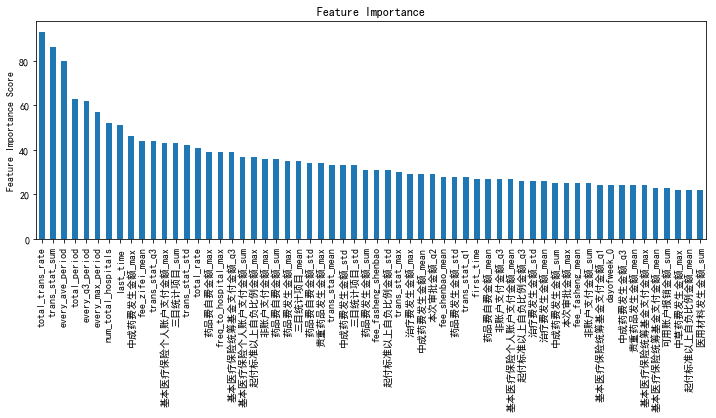

In [160]:
# choose all predictors except target & IDcols
# predictors = [x for x in train.columns if x not in [target]]
xgb1 = XGBClassifier(learning_rate = 0.1,
                    n_estimators=1000,
                    max_depth=5,
                    min_child_weight=1,
                    gamma=0,
                    subsample=0.9,
                    colsample_bytree=0.9,
                    objective='binary:logistic',
                    nthread=4,
                    scale_pos_weight=1,
                    seed=27)
feat_nonsparse_imp1 = modelfit(xgb1,df_train,df_test,predictors)

In [162]:
feat_nonsparse_imp1.to_csv("feat_nonsparse_imp.csv",encoding="utf-8")

In [164]:
feat_nonsparse_imp1[-60:]

城乡救助补助金额_std          3
床位费发生金额_std           3
every_q2_period       3
检查费自费金额_max           3
医疗救助个人按比例负担金额_sum     3
医用材料费自费金额_std         3
every_min_period      3
贵重检查费金额_sum           3
检查费申报金额_max           3
床位费发生金额_max           3
城乡救助补助金额_max          2
治疗费发生金额_q2            2
检查费发生金额_q2            2
医用材料发生金额_q1           2
医疗救助医院申请_max          2
城乡救助补助金额_mean         2
治疗费自费金额_std           2
治疗费申报金额_q1            2
fee_fasheng_sum       2
一次性医用材料申报金额_q1        2
其它发生金额_q3             2
民政救助补助金额_q2           2
三目统计项目_q2             2
补助审批金额_q2             2
医疗救助个人按比例负担金额_q3      2
补助审批金额_sum            2
补助审批金额_q3             2
床位费申报金额_mean          2
手术费发生金额_sum           2
中草药费发生金额_q3           2
医用材料费自费金额_sum         2
药品费自费金额_q2            1
fee_zhifu_sum         1
贵重检查费金额_max           1
贵重药品发生金额_q2           1
补助审批金额_q1             1
贵重检查费金额_std           1
民政救助补助金额_max          1
治疗费自费金额_sum           1
治疗费申报金额_q2            1
基本医疗保险个人账户支付金额_q1     1
城乡救助补助金额_q3     

# 原有所有特征重要性

In [168]:
# 去除重复的特征
dups = duplicate_columns(df_train_test)

In [170]:
predictors = features.difference(dups)

In [172]:
len(predictors)

1106

[0]	train-auc:0.806079+0.0104252	test-auc:0.780669+0.0286913
[10]	train-auc:0.899009+0.00809422	test-auc:0.858609+0.0193202
[20]	train-auc:0.933572+0.0042928	test-auc:0.879663+0.0164438
[30]	train-auc:0.957889+0.000640671	test-auc:0.897018+0.00804159
[40]	train-auc:0.973095+0.00138492	test-auc:0.904993+0.0094624
[50]	train-auc:0.982354+0.000819926	test-auc:0.909178+0.0105825
[60]	train-auc:0.987697+0.000739164	test-auc:0.911292+0.00924606
[70]	train-auc:0.991701+0.00059367	test-auc:0.912405+0.0086862
[80]	train-auc:0.993895+0.000288776	test-auc:0.912159+0.00957668
[90]	train-auc:0.995488+0.00048348	test-auc:0.912469+0.00963273
[100]	train-auc:0.996873+0.000468825	test-auc:0.912166+0.00959
[110]	train-auc:0.997877+0.00041123	test-auc:0.912822+0.00943599
[120]	train-auc:0.998471+0.000379697	test-auc:0.913241+0.00982651
[130]	train-auc:0.999007+0.000209424	test-auc:0.913611+0.00928907
[140]	train-auc:0.999343+0.000188145	test-auc:0.913712+0.00921958
[150]	train-auc:0.999573+0.000140878	te

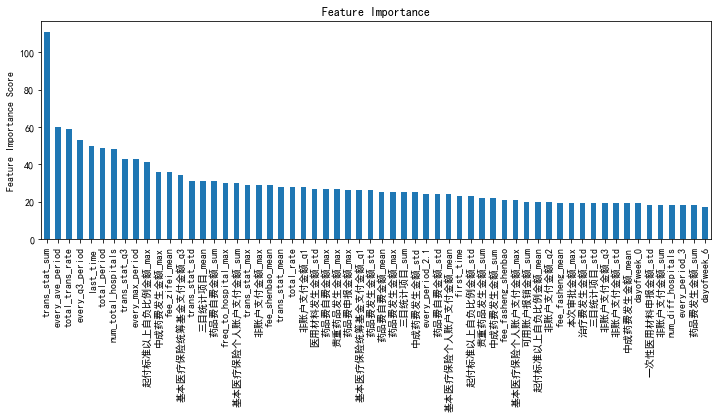

In [173]:
# choose all predictors except target & IDcols
# predictors = [x for x in train.columns if x not in [target]]
xgb1 = XGBClassifier(learning_rate = 0.1,
                    n_estimators=1000,
                    max_depth=5,
                    min_child_weight=1,
                    gamma=0,
                    subsample=0.9,
                    colsample_bytree=0.9,
                    objective='binary:logistic',
                    nthread=4,
                    scale_pos_weight=1,
                    seed=27)
feat_all_imp1 = modelfit(xgb1,df_train,df_test,predictors)

In [174]:
feat_all_imp1[-60:]

公务员医疗补助基金支付金额_q2           2
城乡救助补助金额_q3                2
检查费发生金额_q3                 2
every_period_15            2
every_period_10            2
医疗救助医院申请_q3                1
药品费自费金额_q2                 1
贵重药品发生金额_q3                1
城乡救助补助金额_q2                1
公务员医疗补助基金支付金额_sum          1
治疗费自费金额_sum                1
贵重检查费金额_mean               1
手术费发生金额_sum                1
补助审批金额_q2                  1
every_min_period           1
一次性医用材料申报金额_q2             1
freq_hospital_186          1
fee_shenbao_sum            1
freq_trans_hospital_704    1
freq_trans_hospital_170    1
城乡救助补助金额_sum               1
freq_trans_hospital_186    1
医疗救助个人按比例负担金额_std          1
freq_trans_hospital_189    1
床位费申报金额_mean               1
freq_trans_hospital_34     1
freq_trans_hospital_567    1
freq_trans_hospital_98     1
三目统计项目_max                 1
医疗救助个人按比例负担金额_q3           1
床位费发生金额_std                1
民政救助补助金额_sum               1
民政救助补助金额_q3                1
民政救助补助金额_q2                1
检查费自费金额_sum   

# 所有特征（去除重复）重要性排序2000+

## 特征合并

In [176]:
# Training Data
df_disease_feat = pd.read_csv("df_disease_feat_train_clean.csv",index_col='个人编码')
df_service_feat = pd.read_csv("df_service_feat_train_clean.csv",index_col='个人编码')
df_service_stats_feat = pd.read_csv("feat_service_stats_train.csv",index_col='个人编码')
df_origin_feat_target = pd.read_csv("df_data_train_clean_sparse_latest.csv",index_col="个人编码")

In [178]:
pd.concat([df_origin_feat_target,
          df_service_stats_feat,
          df_service_feat,
          df_disease_feat],axis=1).to_csv("total_feat_train.csv")

In [179]:
del df_disease_feat
del df_service_feat
del df_service_stats_feat
del df_origin_feat_target

In [31]:
# Testing Data
df_disease_feat = pd.read_csv("df_disease_feat_test_clean.csv",index_col='个人编码')
df_service_feat = pd.read_csv("df_service_feat_test_clean.csv",index_col='个人编码')
df_service_feat.columns = df_service_feat.columns.str.replace("[\[\]]",'_').str.replace("<","_").str.replace("☆","_").str.replace("、","_")
df_service_feat.to_csv("df_service_feat_train_clean.csv")

df_service_stats_feat = pd.read_csv("feat_service_stats_test.csv",index_col='个人编码')
df_origin_feat_target = pd.read_csv("df_data_test_clean_sparse_latest.csv",index_col="个人编码")

In [32]:
pd.concat([df_origin_feat_target,
          df_service_stats_feat,
          df_service_feat,
          df_disease_feat],axis=1).to_csv("total_feat_test.csv")

In [33]:
del df_disease_feat
del df_service_feat
del df_service_stats_feat
del df_origin_feat_target

## 导入特征数据

In [4]:
df_train_test = pd.read_csv("total_feat_train.csv",index_col="个人编码")

["service_未知","disease_未知","first_time"],还有一些共线性特征["fee_shenbao"]等

In [5]:
# 所有特征
features = df_train_test.columns.difference(['target'])

In [6]:
features.size

3716

In [6]:
# 重复的只有间隔特征，所以只需要去除这个重复的即可
period_predictors = features[features.str.startswith("every_period_")]

In [7]:
# 去除重复的列
def duplicate_columns(frame):
    groups = frame.columns.to_series().groupby(frame.dtypes).groups
    dups = []
    for t, v in groups.items():
        dcols = frame[v].to_dict(orient="list")

        vs = dcols.values()
        ks = dcols.keys()
        lvs = len(vs)

        for i in range(lvs):
            for j in range(i+1,lvs):
                if vs[i] == vs[j]: 
                    dups.append(ks[i])
                    break

    return dups

dups = duplicate_columns(df_train_test[features])

In [8]:
len(dups)

137

In [8]:
# 摈弃明显不合理的特征？ 需进一步分析" service_未知","disease_未知",
predictors = features.difference(dups).difference(["first_time"])
target = 'target'

In [10]:
len(predictors)

3578

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit
ss = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=0)
idx_train, idx_test = ss.split(df_train_test[predictors],df_train_test[target]).next()
print 'train: ',len(idx_train)
print 'test: ',len(idx_test)
print 'ratio',float(len(idx_test))/(len(idx_train)+len(idx_test))

train:  16000
test:  4000
ratio 0.2


In [10]:
df_train = df_train_test.iloc[idx_train,:]
df_test = df_train_test.iloc[idx_test,:]

In [13]:
df_train.shape

(16000, 3717)

In [14]:
df_train[predictors].shape

(16000, 3578)

In [15]:
len(predictors)

3578

# Feature Importance

[0]	train-auc:0.816325+0.00949654	test-auc:0.798629+0.029759
[10]	train-auc:0.907059+0.00605142	test-auc:0.873476+0.0178329
[20]	train-auc:0.942986+0.00351061	test-auc:0.89837+0.0110774
[30]	train-auc:0.965196+0.00174648	test-auc:0.909029+0.0109225
[40]	train-auc:0.979956+0.000929201	test-auc:0.920358+0.00825573
[50]	train-auc:0.986992+0.000803097	test-auc:0.924613+0.00797623
[60]	train-auc:0.990888+0.000806158	test-auc:0.925613+0.00658931
[70]	train-auc:0.993682+0.000562953	test-auc:0.926682+0.00609981
[80]	train-auc:0.995606+0.000416501	test-auc:0.927792+0.00636059
[90]	train-auc:0.997034+0.000477846	test-auc:0.927508+0.00628848
[100]	train-auc:0.997891+0.00037227	test-auc:0.927483+0.00631619
[110]	train-auc:0.998625+0.000225652	test-auc:0.926791+0.00618557
[120]	train-auc:0.999061+0.000195425	test-auc:0.926867+0.00671504
[130]	train-auc:0.999414+0.000116583	test-auc:0.926873+0.00680412
[140]	train-auc:0.999636+0.000117189	test-auc:0.926658+0.00698595

Model Report
n_estimators:  94


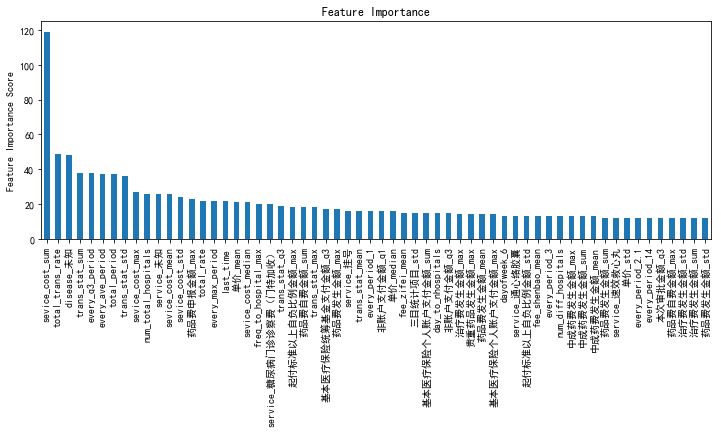

In [18]:
# choose all predictors except target & IDcols
# predictors = [x for x in train.columns if x not in [target]]
xgb1 = XGBClassifier(learning_rate = 0.1,
                    n_estimators=1000,
                    max_depth=5,
                    min_child_weight=1,
                    gamma=0,
                    subsample=0.9,
                    colsample_bytree=1,
                    objective='binary:logistic',
                    nthread=4,
                    scale_pos_weight=1,
                    seed=27)
feat_all_imp1 = modelfit(xgb1,df_train,df_test,predictors)

In [23]:
feat_all_imp1.size

318

## Drop the Nonsense Features

[0]	train-auc:0.819604+0.00893286	test-auc:0.803421+0.0214869
[10]	train-auc:0.903285+0.00150054	test-auc:0.871041+0.0169903
[20]	train-auc:0.94243+0.0036834	test-auc:0.89784+0.011439
[30]	train-auc:0.965368+0.00201575	test-auc:0.911322+0.00987173
[40]	train-auc:0.979749+0.00105845	test-auc:0.918356+0.00858119
[50]	train-auc:0.987306+0.000723525	test-auc:0.920742+0.00794641
[60]	train-auc:0.991488+0.000433094	test-auc:0.922781+0.00738036
[70]	train-auc:0.994038+0.000465527	test-auc:0.923548+0.00803613
[80]	train-auc:0.995964+0.000422456	test-auc:0.92442+0.0080138
[90]	train-auc:0.997228+0.0003684	test-auc:0.924306+0.00766118
[100]	train-auc:0.997992+0.000234011	test-auc:0.924711+0.00724851
[110]	train-auc:0.998719+0.000230989	test-auc:0.925413+0.00748931
[120]	train-auc:0.999161+0.000133855	test-auc:0.925447+0.00767473
[130]	train-auc:0.999445+0.000121515	test-auc:0.925419+0.00761161
[140]	train-auc:0.999658+0.0001054	test-auc:0.925004+0.00752932
[150]	train-auc:0.999817+5.91696e-05	te

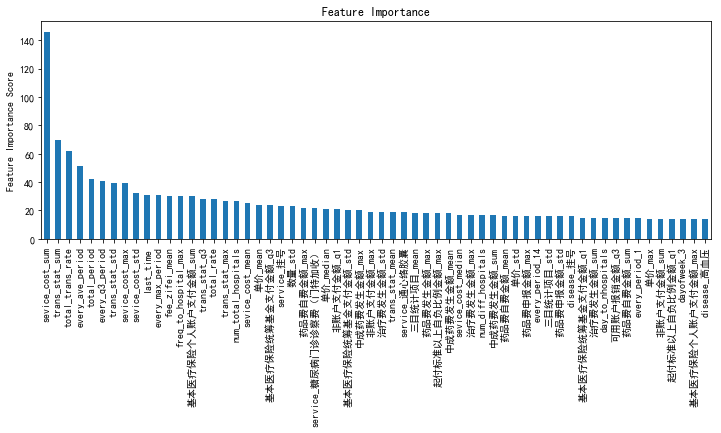

In [21]:
predictors = features.difference(dups).difference(["service_未知","disease_未知","first_time"])

xgb2 = XGBClassifier(learning_rate = 0.1,
                    n_estimators=1000,
                    max_depth=5,
                    min_child_weight=1,
                    gamma=0,
                    subsample=0.9,
                    colsample_bytree=1,
                    objective='binary:logistic',
                    nthread=4,
                    scale_pos_weight=1,
                    seed=27)
feat_all_imp2 = modelfit(xgb2,df_train,df_test,predictors)

In [22]:
feat_all_imp2.size

331

In [25]:
feat_all_imp1.index.difference(feat_all_imp2.index)

Index([u'disease_未知', u'disease_气虚血瘀', u'disease_癌症放化疗', u'disease_糖尿病性肾病',
       u'disease_肝功能异常', u'disease_肾移植术后', u'disease_肾透析', u'disease_高血脂',
       u'every_period_15', u'every_period_21', u'every_period_37.1',
       u'freq_hospital_1072', u'freq_hospital_115', u'freq_hospital_1254',
       u'freq_hospital_140', u'freq_hospital_182', u'freq_hospital_185',
       u'freq_hospital_189', u'freq_hospital_196', u'freq_hospital_65',
       u'freq_trans_hospital_1072', u'freq_trans_hospital_186',
       u'freq_trans_hospital_196', u'freq_trans_hospital_567',
       u'freq_trans_hospital_587', u'freq_trans_hospital_7', u'service_心可舒片',
       u'service_未知', u'一次性医用材料申报金额_q2', u'公务员医疗补助基金支付金额_max', u'医用材料发生金额_q2',
       u'医疗救助个人按比例负担金额_mean', u'医疗救助个人按比例负担金额_q3', u'城乡救助补助金额_std',
       u'床位费发生金额_max', u'检查费申报金额_q3', u'民政救助补助金额_q1', u'民政救助补助金额_q3',
       u'治疗费发生金额_q1', u'治疗费申报金额_q1', u'治疗费申报金额_q3', u'治疗费自费金额_q3',
       u'贵重检查费金额_mean', u'贵重检查费金额_sum'],
      dtype='object')

## Increasing the Tree Depth

[0]	train-auc:0.855985+0.00508862	test-auc:0.814217+0.0261544
[10]	train-auc:0.957431+0.00484806	test-auc:0.88314+0.020605
[20]	train-auc:0.986224+0.00243813	test-auc:0.90471+0.014489
[30]	train-auc:0.997068+0.000436041	test-auc:0.912085+0.0132941
[40]	train-auc:0.99959+6.07836e-05	test-auc:0.91673+0.0109475
[50]	train-auc:0.999957+2.16111e-05	test-auc:0.920798+0.0102743
[60]	train-auc:0.999999+7.48331e-07	test-auc:0.923075+0.00860329
[70]	train-auc:1+0	test-auc:0.924584+0.00722041
[80]	train-auc:1+0	test-auc:0.925098+0.00745339
[90]	train-auc:1+0	test-auc:0.925465+0.00715256
[100]	train-auc:1+0	test-auc:0.925973+0.00719567
[110]	train-auc:1+0	test-auc:0.92684+0.00697881
[120]	train-auc:1+0	test-auc:0.927083+0.00731961
[130]	train-auc:1+0	test-auc:0.927737+0.00730885
[140]	train-auc:1+0	test-auc:0.927888+0.00732451
[150]	train-auc:1+0	test-auc:0.928469+0.0067098
[160]	train-auc:1+0	test-auc:0.928325+0.00678788
[170]	train-auc:1+0	test-auc:0.928113+0.007156
[180]	train-auc:1+0	test-auc:

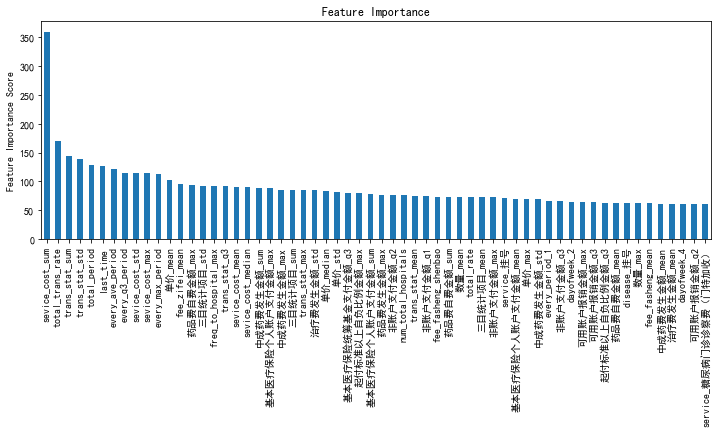

In [26]:
predictors = features.difference(dups).difference(["service_未知","disease_未知","first_time"])

xgb3 = XGBClassifier(learning_rate = 0.1,
                    n_estimators=1000,
                    max_depth=9,
                    min_child_weight=1,
                    gamma=0,
                    subsample=0.9,
                    colsample_bytree=1,
                    objective='binary:logistic',
                    nthread=4,
                    scale_pos_weight=1,
                    seed=27)
feat_all_imp3 = modelfit(xgb3,df_train,df_test,predictors)

In [27]:
feat_all_imp3.size

452

## Increasing the Potential Features 

[0]	train-auc:0.794727+0.0111826	test-auc:0.772006+0.0251924
[10]	train-auc:0.916989+0.00451286	test-auc:0.879156+0.0177812
[20]	train-auc:0.944443+0.00226807	test-auc:0.900855+0.0114441
[30]	train-auc:0.963345+0.00275111	test-auc:0.910182+0.00906374
[40]	train-auc:0.976985+0.00155502	test-auc:0.917372+0.00918448
[50]	train-auc:0.984574+0.00141142	test-auc:0.922212+0.0089278
[60]	train-auc:0.989283+0.00104417	test-auc:0.923168+0.00769562
[70]	train-auc:0.992629+0.000514316	test-auc:0.925217+0.00792208
[80]	train-auc:0.994799+0.000395143	test-auc:0.925489+0.00817918
[90]	train-auc:0.996283+0.000111151	test-auc:0.926037+0.00823728
[100]	train-auc:0.997358+0.000161517	test-auc:0.925499+0.00739604
[110]	train-auc:0.998216+0.000117707	test-auc:0.925346+0.0070491
[120]	train-auc:0.998765+0.000101158	test-auc:0.925625+0.0070654
[130]	train-auc:0.999192+9.27953e-05	test-auc:0.926162+0.00675303
[140]	train-auc:0.999508+9.5618e-05	test-auc:0.92523+0.00706062
[150]	train-auc:0.999684+6.63307e-05	

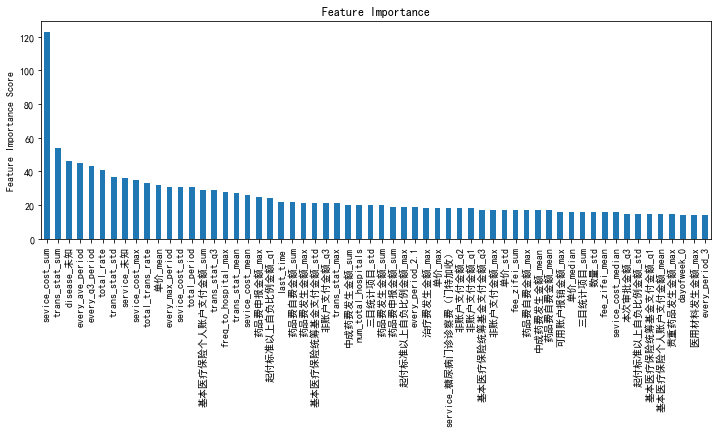

In [28]:
predictors = features.difference(dups).difference(["first_time"])  # "service_未知","disease_未知",

xgb4 = XGBClassifier(learning_rate = 0.1,
                    n_estimators=1000,
                    max_depth=5,
                    min_child_weight=1,
                    gamma=0,
                    subsample=0.9,
                    colsample_bytree=0.5,
                    objective='binary:logistic',
                    nthread=4,
                    scale_pos_weight=1,
                    seed=27)
feat_all_imp4 = modelfit(xgb4,df_train,df_test,predictors)

In [29]:
feat_all_imp4.size

359

[0]	train-auc:0.798847+0.0106317	test-auc:0.778732+0.0202146
[10]	train-auc:0.913639+0.00788463	test-auc:0.878157+0.0266419
[20]	train-auc:0.945126+0.00258814	test-auc:0.898245+0.0139446
[30]	train-auc:0.962415+0.00174348	test-auc:0.907444+0.00967292
[40]	train-auc:0.975823+0.000505149	test-auc:0.915485+0.008419
[50]	train-auc:0.983631+0.00108579	test-auc:0.920779+0.00653385
[60]	train-auc:0.98893+0.000798825	test-auc:0.921825+0.00488491
[70]	train-auc:0.992096+0.000721826	test-auc:0.922593+0.00520697
[80]	train-auc:0.994296+0.00049624	test-auc:0.92335+0.00522129
[90]	train-auc:0.99595+0.00047722	test-auc:0.923158+0.00577951
[100]	train-auc:0.997175+0.000416286	test-auc:0.922874+0.00630012
[110]	train-auc:0.998063+0.000263236	test-auc:0.923749+0.006709
[120]	train-auc:0.99859+0.000286527	test-auc:0.923992+0.00622526
[130]	train-auc:0.999071+0.000203821	test-auc:0.923332+0.00648735
[140]	train-auc:0.999371+0.000182665	test-auc:0.923355+0.00652771
[150]	train-auc:0.999579+0.000152159	tes

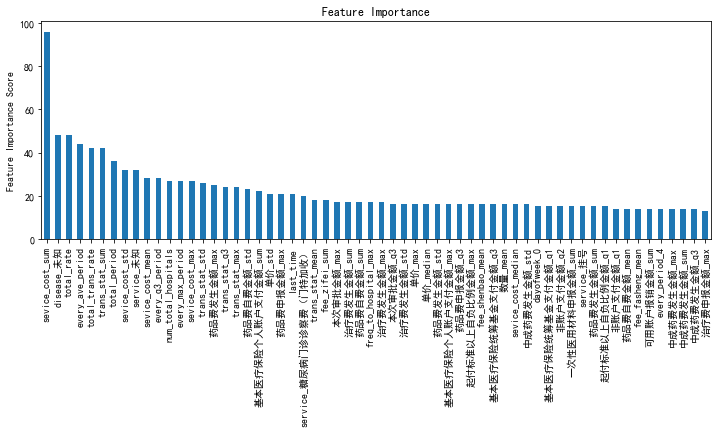

In [30]:
predictors = features.difference(dups).difference(["first_time"])  # "service_未知","disease_未知",

xgb5 = XGBClassifier(learning_rate = 0.1,
                    n_estimators=1000,
                    max_depth=5,
                    min_child_weight=1,
                    gamma=0,
                    subsample=0.9,
                    colsample_bytree=0.3,
                    objective='binary:logistic',
                    nthread=4,
                    scale_pos_weight=1,
                    seed=27)
feat_all_imp5 = modelfit(xgb5,df_train,df_test,predictors)

In [31]:
feat_all_imp5.size

363

[0]	train-auc:0.688118+0.0153146	test-auc:0.659577+0.0220905
[10]	train-auc:0.911008+0.00180378	test-auc:0.875517+0.0260224
[20]	train-auc:0.940544+0.0037156	test-auc:0.897248+0.0121117
[30]	train-auc:0.95678+0.00335807	test-auc:0.906628+0.00970766
[40]	train-auc:0.969355+0.00215385	test-auc:0.911631+0.00780399
[50]	train-auc:0.977576+0.00149741	test-auc:0.913932+0.00788765
[60]	train-auc:0.983777+0.00128769	test-auc:0.918377+0.00749352
[70]	train-auc:0.987965+0.000766726	test-auc:0.919773+0.0070478
[80]	train-auc:0.990601+0.000716105	test-auc:0.920403+0.00595313
[90]	train-auc:0.992826+0.00063062	test-auc:0.920254+0.00673534
[100]	train-auc:0.994396+0.000506046	test-auc:0.920608+0.00720887
[110]	train-auc:0.995783+0.000521531	test-auc:0.921687+0.00705412
[120]	train-auc:0.99685+0.000480777	test-auc:0.922721+0.00689604
[130]	train-auc:0.997729+0.000289866	test-auc:0.923153+0.00685289
[140]	train-auc:0.998302+0.000330729	test-auc:0.923412+0.00665249
[150]	train-auc:0.99875+0.000247423	t

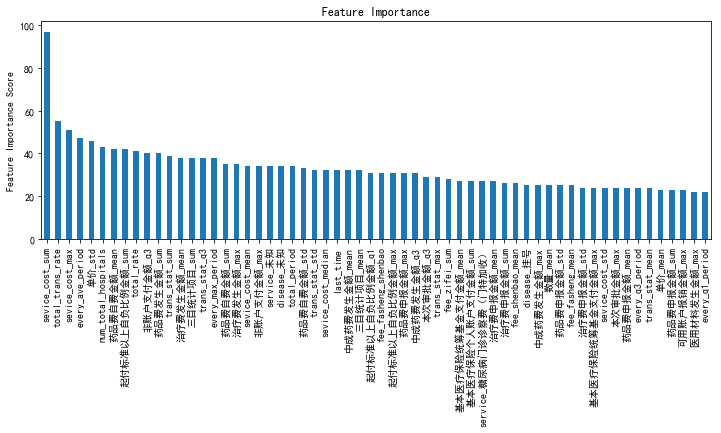

In [32]:
predictors = features.difference(dups).difference(["first_time"])  # "service_未知","disease_未知",

xgb6 = XGBClassifier(learning_rate = 0.1,
                    n_estimators=1000,
                    max_depth=5,
                    min_child_weight=1,
                    gamma=0,
                    subsample=0.9,
                    colsample_bytree=0.1,
                    objective='binary:logistic',
                    nthread=4,
                    scale_pos_weight=1,
                    seed=27)
feat_all_imp6 = modelfit(xgb6,df_train,df_test,predictors)

In [33]:
feat_all_imp6.size

415

## Best Feature Union

In [34]:
all_feature_imp = pd.concat([feat_all_imp1,feat_all_imp2,feat_all_imp3,feat_all_imp4,feat_all_imp5,feat_all_imp6])

In [37]:
all_feature_imp = all_feature_imp.sort_values(ascending=False)

In [58]:
all_feature_imp.to_csv("all_feature_imp.csv",encoding='utf-8')

In [11]:
all_feature_imp = pd.read_csv("all_feature_imp.csv",index_col=0)

In [60]:
all_feature_imp.index.unique().size

550

In [12]:
final_features = all_feature_imp.index.unique()

# Feature Seletion - A Random Method with xgboost

# Try The Features Selected

In [13]:
predictors = final_features

In [63]:
predictors

Index([u'total_trans_rate', u'sevice_cost_sum', u'trans_stat_sum',
       u'trans_stat_std', u'total_period', u'last_time', u'every_ave_period',
       u'every_q3_period', u'sevice_cost_std', u'sevice_cost_max',
       ...
       u'freq_hospital_153', u'freq_hospital_1058', u'every_period_41',
       u'every_period_36', u'every_period_32', u'every_period_31',
       u'every_period_26', u'freq_trans_hospital_1129',
       u'freq_trans_hospital_143', u'高价材料发生金额_std'],
      dtype='object', name=u'sevice_cost_sum', length=550)

In [64]:
df_train.columns

Index([u'药品费发生金额_sum', u'贵重药品发生金额_sum', u'中成药费发生金额_sum', u'中草药费发生金额_sum',
       u'药品费自费金额_sum', u'药品费申报金额_sum', u'检查费发生金额_sum', u'贵重检查费金额_sum',
       u'检查费自费金额_sum', u'检查费申报金额_sum',
       ...
       u'disease_高血脂一线降脂药效果不佳', u'disease_高血脂偏瘫', u'disease_高血脂冠心病偏瘫',
       u'disease_高血脂症', u'disease_高血脂症血瘀证', u'disease_高黏滞血症', u'disease_高黏血症',
       u'disease_鼻咽癌', u'disease_鼻炎', u'total_kind_disease'],
      dtype='object', length=3717)

In [14]:
df_train.shape

(16000, 3717)

## Step 1-Find the number of estimators for a high learning rate

[0]	train-auc:0.816338+0.00952796	test-auc:0.798907+0.0298222
[10]	train-auc:0.908598+0.00876177	test-auc:0.874444+0.0206549
[20]	train-auc:0.944182+0.00291068	test-auc:0.899002+0.00992942
[30]	train-auc:0.965526+0.00199673	test-auc:0.910099+0.0100354
[40]	train-auc:0.979873+0.00102573	test-auc:0.917683+0.00813171
[50]	train-auc:0.987391+0.00113631	test-auc:0.921629+0.00807113
[60]	train-auc:0.991544+0.000653261	test-auc:0.923795+0.00786958
[70]	train-auc:0.994136+0.000510222	test-auc:0.924559+0.00735513
[80]	train-auc:0.995971+0.000271631	test-auc:0.92592+0.00723069
[90]	train-auc:0.997299+0.000237887	test-auc:0.926157+0.00734825
[100]	train-auc:0.998033+0.000261341	test-auc:0.926029+0.00758984
[110]	train-auc:0.998702+0.000215454	test-auc:0.926556+0.00819302
[120]	train-auc:0.999125+0.000147235	test-auc:0.925871+0.00821242
[130]	train-auc:0.999419+6.82214e-05	test-auc:0.926306+0.00867393
[140]	train-auc:0.999618+6.85682e-05	test-auc:0.926624+0.0083184
[150]	train-auc:0.999783+3.75446

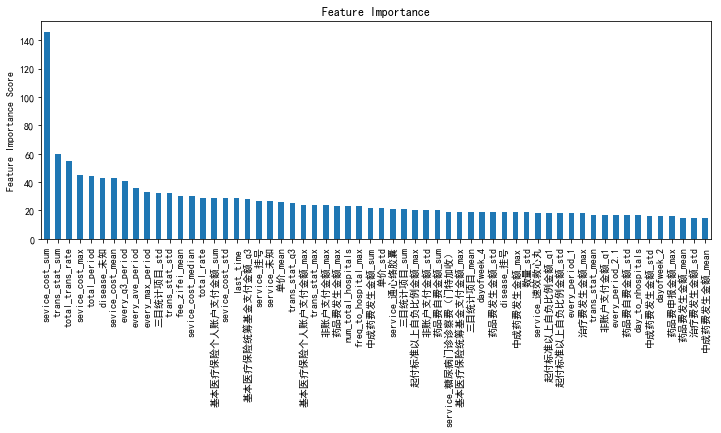

In [90]:
xgb7 = XGBClassifier(learning_rate = 0.1,
                    n_estimators=1000,
                    max_depth=5,
                    min_child_weight=1,
                    gamma=0,
                    subsample=0.9,
                    colsample_bytree=1,
                    objective='binary:logistic',
                    nthread=4,
                    scale_pos_weight=1,
                    seed=27)
feat_final_imp = modelfit(xgb7,df_train,df_test,predictors)

## step 2-Tune max_depth and min_child_weight

In [97]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test1 = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
                                        min_child_weight=1, gamma=0, subsample=0.9, colsample_bytree=1,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
                       param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(df_train[predictors],df_train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=140, nthread=4,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.9),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'max_depth': [3, 5, 7, 9], 'min_child_weight': [1, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [98]:
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.92125, std: 0.01101, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.92249, std: 0.01031, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.92115, std: 0.01094, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.92730, std: 0.00846, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.92527, std: 0.00957, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.92339, std: 0.01128, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.92322, std: 0.00978, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.92274, std: 0.01014, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.92487, std: 0.01038, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 0.92672, std: 0.01094, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: 0.92679, std: 0.01107, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: 0.92292, std: 0.01045, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 5, 'min_child_weight': 1

## step 3-Tune gamma

In [99]:
#'gamma':[i/10.0 for i in range(0,2)]
param_test3 = {
 'gamma':[0,0.01,0.05]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
                                        min_child_weight=1, gamma=0, subsample=0.9, colsample_bytree=1,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
                       param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(df_train[predictors],df_train[target])
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.92730, std: 0.00846, params: {'gamma': 0},
  mean: 0.92623, std: 0.01124, params: {'gamma': 0.01},
  mean: 0.92609, std: 0.01007, params: {'gamma': 0.05}],
 {'gamma': 0},
 0.927297697368421)

[0]	train-auc:0.816338+0.00952796	test-auc:0.798907+0.0298222
[10]	train-auc:0.908598+0.00876177	test-auc:0.874444+0.0206549
[20]	train-auc:0.944182+0.00291068	test-auc:0.899002+0.00992942
[30]	train-auc:0.965526+0.00199673	test-auc:0.910099+0.0100354
[40]	train-auc:0.979873+0.00102573	test-auc:0.917683+0.00813171
[50]	train-auc:0.987391+0.00113631	test-auc:0.921629+0.00807113
[60]	train-auc:0.991544+0.000653261	test-auc:0.923795+0.00786958
[70]	train-auc:0.994136+0.000510222	test-auc:0.924559+0.00735513
[80]	train-auc:0.995971+0.000271631	test-auc:0.92592+0.00723069
[90]	train-auc:0.997299+0.000237887	test-auc:0.926157+0.00734825
[100]	train-auc:0.998033+0.000261341	test-auc:0.926029+0.00758984
[110]	train-auc:0.998702+0.000215454	test-auc:0.926556+0.00819302
[120]	train-auc:0.999125+0.000147235	test-auc:0.925871+0.00821242
[130]	train-auc:0.999419+6.82214e-05	test-auc:0.926306+0.00867393
[140]	train-auc:0.999618+6.85682e-05	test-auc:0.926624+0.0083184
[150]	train-auc:0.999783+3.75446

sevice_cost_sum             146
trans_stat_sum               60
total_trans_rate             55
sevice_cost_max              45
total_period                 44
disease_未知                   43
sevice_cost_mean             43
every_q3_period              41
every_ave_period             36
every_max_period             33
三目统计项目_std                   32
trans_stat_std               32
fee_zifei_mean               30
sevice_cost_median           30
total_rate                   29
基本医疗保险个人账户支付金额_sum           29
sevice_cost_std              29
last_time                    29
基本医疗保险统筹基金支付金额_q3            28
service_挂号                   27
service_未知                   27
单价_mean                      26
trans_stat_q3                25
基本医疗保险个人账户支付金额_max           24
trans_stat_max               24
非账户支付金额_max                  24
药品费发生金额_max                  23
num_total_hospitals          23
freq_to_hospital_max         23
中成药费发生金额_sum                 22
单价_std                       22
service_

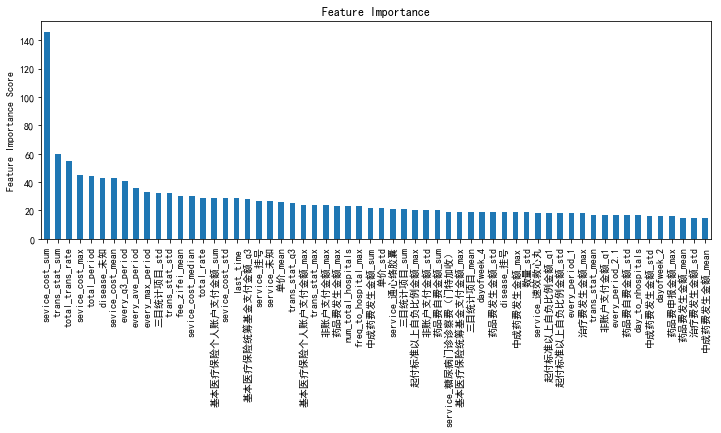

In [102]:
# Re-calibrate the number of boosting rounds for the updated parameters
xgb8 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.9,
 colsample_bytree=1,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb8, df_train, df_test,predictors)

## Tune subsample and colsample_bytree

In [103]:
param_test4 = {
 'subsample':[i/10.0 for i in range(8,11)],
 'colsample_bytree':[i/10.0 for i in range(7,11)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
                                        min_child_weight=1, gamma=0, subsample=0.9, colsample_bytree=1,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(df_train[predictors],df_train[target])
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.92266, std: 0.01132, params: {'subsample': 0.8, 'colsample_bytree': 0.7},
  mean: 0.92515, std: 0.01024, params: {'subsample': 0.9, 'colsample_bytree': 0.7},
  mean: 0.92216, std: 0.00984, params: {'subsample': 1.0, 'colsample_bytree': 0.7},
  mean: 0.92409, std: 0.00747, params: {'subsample': 0.8, 'colsample_bytree': 0.8},
  mean: 0.92626, std: 0.01144, params: {'subsample': 0.9, 'colsample_bytree': 0.8},
  mean: 0.92384, std: 0.01100, params: {'subsample': 1.0, 'colsample_bytree': 0.8},
  mean: 0.92581, std: 0.01196, params: {'subsample': 0.8, 'colsample_bytree': 0.9},
  mean: 0.92472, std: 0.00958, params: {'subsample': 0.9, 'colsample_bytree': 0.9},
  mean: 0.92527, std: 0.00838, params: {'subsample': 1.0, 'colsample_bytree': 0.9},
  mean: 0.92653, std: 0.01045, params: {'subsample': 0.8, 'colsample_bytree': 1.0},
  mean: 0.92730, std: 0.00846, params: {'subsample': 0.9, 'colsample_bytree': 1.0},
  mean: 0.92402, std: 0.01066, params: {'subsample': 1.0, 'colsample_bytree'

## Step 5: Tuning Regularization Parameters

In [104]:
# 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
param_test6 = {
 'reg_alpha':[0,1e-5, 1e-2]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
                                        min_child_weight=1, gamma=0, subsample=0.9, colsample_bytree=1,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6.fit(df_train[predictors],df_train[target])
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

([mean: 0.92730, std: 0.00846, params: {'reg_alpha': 0},
  mean: 0.92730, std: 0.00846, params: {'reg_alpha': 1e-05},
  mean: 0.92644, std: 0.01049, params: {'reg_alpha': 0.01}],
 {'reg_alpha': 0},
 0.927297697368421)

In [ ]:
xgb9 = XGBClassifier(
 learning_rate =0.1, n_estimators=140, max_depth=5,
                                        min_child_weight=1, gamma=0, subsample=0.9, colsample_bytree=1,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)
modelfit(xgb9, df_train,df_test, predictors)

## Step 6: Reducing Learning Rate

[0]	train-auc:0.816338+0.00952796	test-auc:0.798907+0.0298222
[10]	train-auc:0.856752+0.0139812	test-auc:0.834915+0.0284589
[20]	train-auc:0.871634+0.00888201	test-auc:0.84737+0.0192042
[30]	train-auc:0.879448+0.00377143	test-auc:0.852684+0.0248498
[40]	train-auc:0.889852+0.00641809	test-auc:0.861708+0.0243045
[50]	train-auc:0.900325+0.00649621	test-auc:0.871433+0.0214777
[60]	train-auc:0.904469+0.00694336	test-auc:0.874597+0.0207686
[70]	train-auc:0.908623+0.00638573	test-auc:0.879345+0.0197683
[80]	train-auc:0.912238+0.00594648	test-auc:0.882264+0.018038
[90]	train-auc:0.917065+0.00333716	test-auc:0.886556+0.0155898
[100]	train-auc:0.920345+0.00356956	test-auc:0.889429+0.0145693
[110]	train-auc:0.923377+0.00306025	test-auc:0.890801+0.0142614
[120]	train-auc:0.926065+0.00354767	test-auc:0.89199+0.0138522
[130]	train-auc:0.928997+0.0034555	test-auc:0.893125+0.0137773
[140]	train-auc:0.931252+0.0032839	test-auc:0.894296+0.0136892
[150]	train-auc:0.933838+0.00294528	test-auc:0.895868+0.0

sevice_cost_sum                       1228
trans_stat_sum                         442
total_trans_rate                       412
disease_未知                             409
every_q3_period                        384
every_ave_period                       363
sevice_cost_max                        334
total_period                           320
trans_stat_std                         274
sevice_cost_std                        249
every_max_period                       249
last_time                              244
sevice_cost_mean                       239
total_rate                             237
num_total_hospitals                    226
fee_zifei_mean                         217
service_未知                             214
trans_stat_q3                          213
trans_stat_max                         211
freq_to_hospital_max                   198
单价_mean                                197
基本医疗保险统筹基金支付金额_q3                      191
药品费自费金额_sum                            183
service_挂号 

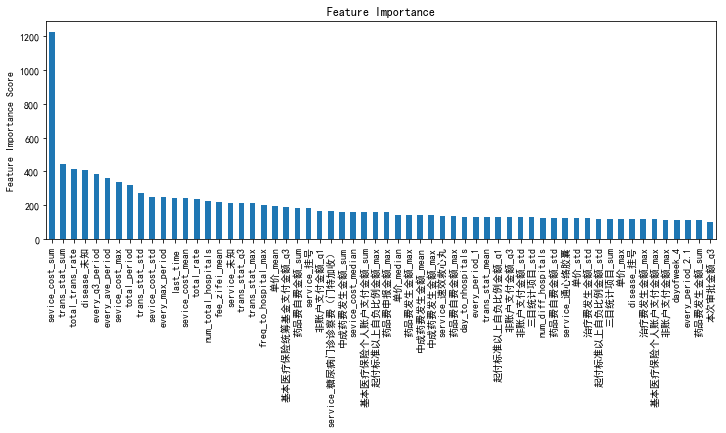

In [105]:
xgb10 = XGBClassifier(
 learning_rate =0.01, n_estimators=5000, 
 max_depth=5, min_child_weight=1, gamma=0, 
 subsample=0.9, colsample_bytree=1,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)
modelfit(xgb10, df_train,df_test, predictors)

## Train and Predict

In [15]:
xgb = XGBClassifier(
 learning_rate =0.01,
 n_estimators=924,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.9,
 colsample_bytree=1,
 reg_alpha=0,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
xgb.fit(df_train[predictors],df_train[target])

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.01, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=924, nthread=4,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.9)

Accuracy : 0.9677
F1 Score : 0.556701
AUC Score (Test): 0.932193
Classification Report : 
             precision    recall  f1-score   support

          0       0.97      1.00      0.98      3800
          1       0.89      0.41      0.56       200

avg / total       0.97      0.97      0.96      4000



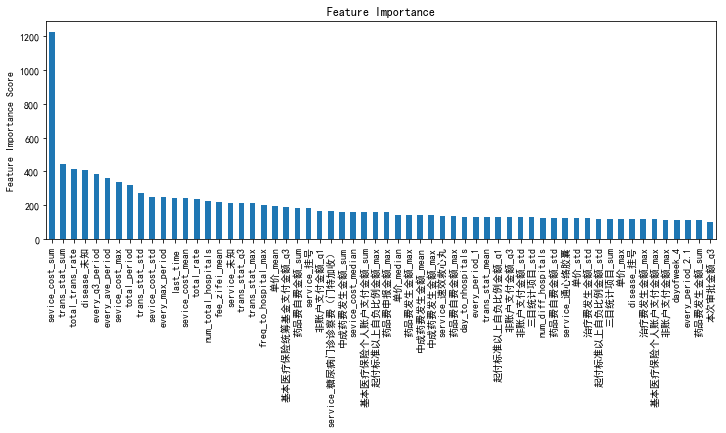

In [16]:
# predict on testing data:
df_test_predictions = xgb.predict(df_test[predictors])
df_test_predprob = xgb.predict_proba(df_test[predictors])[:,1]

print "Accuracy : %.4g" % metrics.accuracy_score(df_test[target], df_test_predictions)
print "F1 Score : %f" % metrics.f1_score(df_test[target],df_test_predictions)
print 'AUC Score (Test): %f' % metrics.roc_auc_score(df_test[target], df_test_predprob)
print "Classification Report : \n", metrics.classification_report(df_test[target],df_test_predictions)

rcParams['figure.figsize'] = 12,4
feat_imp = pd.Series(xgb.booster().get_fscore()).sort_values(ascending=False)
feat_imp[0:60].plot(kind='bar', title='Feature Importance')
plt.ylabel('Feature Importance Score')

## ROC

D:\Program Files\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


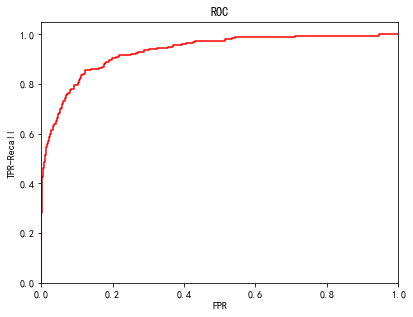

In [17]:
from sklearn.metrics import roc_curve, auc
rcParams['figure.figsize'] = 6.4,4.8
#df_test_predictions = xgb.predict(dtest[predictors])
#df_test_predprob = xgb.predict_proba(dtest[predictors])[:,1]
fpr, tpr, thresholds = roc_curve(df_test[target].values,df_test_predprob)
# Plot Precision-Recall curve
plt.plot(fpr, tpr, color='r')
plt.xlabel('FPR')
plt.ylabel('TPR-Recall')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('ROC')
plt.legend()

## P-R

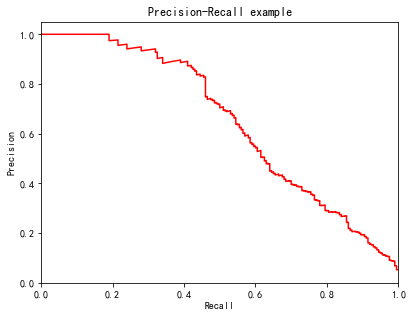

In [18]:
from sklearn.metrics import precision_recall_curve
rcParams['figure.figsize'] = 6.4,4.8
precision, recall, thresholds = precision_recall_curve(df_test[target].values,df_test_predprob)
# Plot Precision-Recall curve
plt.plot(recall, precision, color='r')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall example')
plt.legend()

## Confusion Matrix

In [19]:
import itertools
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
plt.ion()

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Threhold >= 0.0333333333333,  F1 score:  0.325454545455
Threhold >= 0.0666666666667,  F1 score:  0.437414030261
Threhold >= 0.1,  F1 score:  0.491582491582
Threhold >= 0.133333333333,  F1 score:  0.526732673267
Threhold >= 0.166666666667,  F1 score:  0.550660792952
Threhold >= 0.2,  F1 score:  0.572815533981
Threhold >= 0.233333333333,  F1 score:  0.587926509186
Threhold >= 0.266666666667,  F1 score:  0.594285714286
Threhold >= 0.3,  F1 score:  0.585074626866


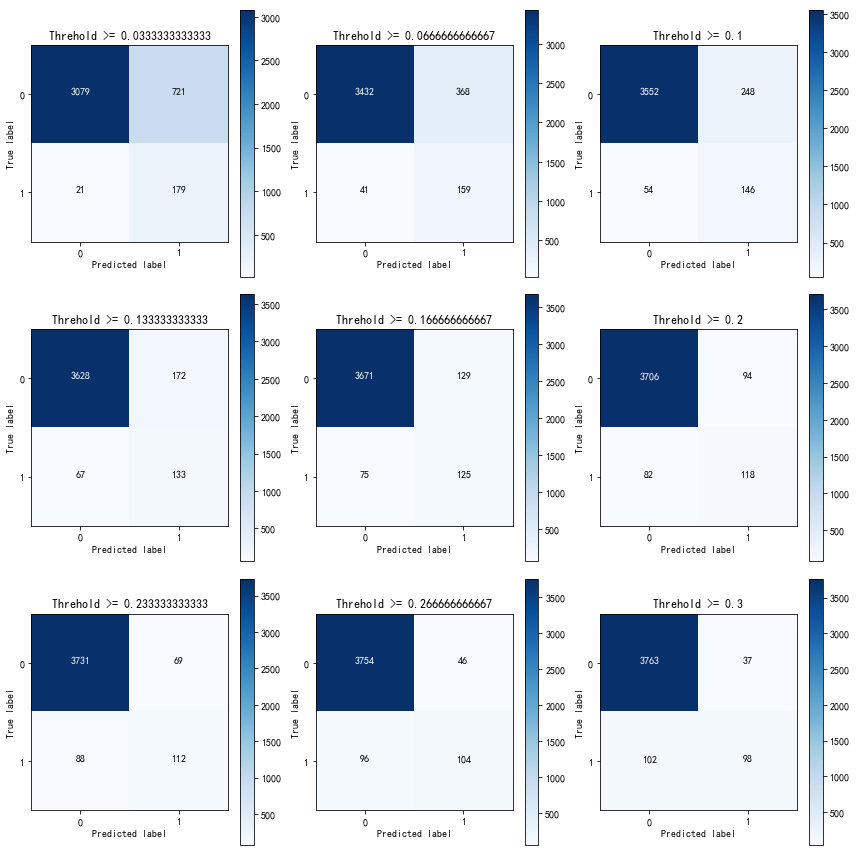

In [23]:
thresholds = np.arange(1,10)/30.0
plt.figure(figsize=(12,12))
j  = 1
for i in thresholds:
    y_test_predictions_high_recall = df_test_predprob > i
    plt.subplot(3,3,j)
    j += 1
    
    # compute confusion matrix
    cnf_matrix = confusion_matrix(df_test[target], y_test_predictions_high_recall)
    #print "Recall metric in the testing dataset: ", float(cnf_matrix[1,1])/(cnf_matrix[0,1]+cnf_matrix[1,1])
    print "Threhold >= %s, "%i,"F1 score: ", metrics.f1_score(df_test[target], y_test_predictions_high_recall)
    
    # plot non-normalized confusion matrix
    class_names = [0,1]
    plot_confusion_matrix(cnf_matrix,classes=class_names,title='Threhold >= %s'%i)

# 总结分析

**现有特征文件**（训练数据与测试数据共有的特征）    
- df_data_train_clean_sparse_latest.csv（包括各款项金额特征，基于时间的用户行为特征）有target；有稀疏特征：
    - freq_hospital_xx
    - freq_trans_xx
    - every_period_xx
- df_service_feat_train.csv（三目服务特征）无target；稀疏
- df_disease_feat_train.csv（出院病种诊断特征）无target；稀疏
- feat_service_stats_train.csv（服务费用，数量统计特征）无target